# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# For evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_style('whitegrid')

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:


# Define a function to load data and aggregate them
def aggregate_stock_data(file_names):

    all_data = []

    for file in file_names:
        # Extract stock name from file name
        stock_name = file.split('_')[0].split('/')[1]

        # Read CSV file
        df = pd.read_csv(file)

        # Convert date to datetime format
        df['Date'] = pd.to_datetime(df['Date'])

        # Rename columns to include stock name for Close, Open, High, Low
        df = df.rename(columns={
            'Close': f'Close{stock_name}',
            'Open': f'Open{stock_name}',
            'High': f'High{stock_name}',
            'Low': f'Low{stock_name}',
            'Volume': f'Volume{stock_name}'
        })

        # Keep only necessary columns
        df = df[['Date', f'Open{stock_name}', f'High{stock_name}',
                 f'Low{stock_name}', f'Close{stock_name}', f'Volume{stock_name}']]

        all_data.append(df)

    # Merge all dataframes on Date
    combined_df = all_data[0]
    for df in all_data[1:]:
        combined_df = pd.merge(combined_df, df, on='Date', how='outer')

    # Sort by date
    combined_df = combined_df.sort_values('Date').reset_index(drop=True)

    return combined_df

In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

# File paths and company names
file_paths = [
    'sampledata/GOOGL_stocks_data.csv',
    'sampledata/IBM_stocks_data.csv',
    'sampledata/AMZN_stocks_data.csv',
    'sampledata/MSFT_stocks_data.csv'
]

company_names = ['Google', 'IBM', 'Amazon', 'Microsoft']

# Load and aggregate data
stock_df  = aggregate_stock_data(file_paths)

# Display first few rows
stock_df.head()

,Date,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,VolumeGOOGL,OpenIBM,HighIBM,LowIBM,CloseIBM,...,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
0,2006-01-03,211.47,218.05,209.32,217.83,13137450.0,82.45,82.55,80.81,82.06,...,47.47,47.85,46.25,47.58,7582127.0,26.25,27.00,26.10,26.84,79974418.0
1,2006-01-04,222.17,224.70,220.09,222.84,15292353.0,82.20,82.50,81.33,81.95,...,47.48,47.73,46.69,47.25,7440914.0,26.77,27.08,26.77,26.97,57975661.0
2,2006-01-05,223.22,226.00,220.97,225.85,10815661.0,81.40,82.90,81.00,82.50,...,47.16,48.20,47.11,47.65,5417258.0,26.96,27.13,26.91,26.99,48247610.0
3,2006-01-06,228.66,235.49,226.85,233.06,17759521.0,83.95,85.03,83.41,84.95,...,47.97,48.58,47.32,47.87,6154285.0,26.89,27.00,26.49,26.91,100969092.0
4,2006-01-09,233.44,236.94,230.70,233.68,12795837.0,84.10,84.25,83.38,83.73,...,46.55,47.10,46.40,47.08,8945056.0,26.93,27.07,26.76,26.86,55627836.0


In [4]:
# View specifics of the data
# Display dataset structure and check for nulls
print("Dataset Info:\n")
stock_df.info()

# Display statistical summary
print("\nStatistical Summary:\n")
print(stock_df.describe())

# Optional: Preview a few rows
print("\nSample Data:\n")
stock_df.head()



Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         3020 non-null   datetime64[ns]
 1   OpenGOOGL    3019 non-null   float64       
 2   HighGOOGL    3019 non-null   float64       
 3   LowGOOGL     3019 non-null   float64       
 4   CloseGOOGL   3019 non-null   float64       
 5   VolumeGOOGL  3019 non-null   float64       
 6   OpenIBM      3019 non-null   float64       
 7   HighIBM      3020 non-null   float64       
 8   LowIBM       3019 non-null   float64       
 9   CloseIBM     3020 non-null   float64       
 10  VolumeIBM    3020 non-null   int64         
 11  OpenAMZN     3019 non-null   float64       
 12  HighAMZN     3019 non-null   float64       
 13  LowAMZN      3019 non-null   float64       
 14  CloseAMZN    3019 non-null   float64       
 15  VolumeAMZN   3019 non-null   float64    

,Date,OpenGOOGL,HighGOOGL,LowGOOGL,CloseGOOGL,VolumeGOOGL,OpenIBM,HighIBM,LowIBM,CloseIBM,...,OpenAMZN,HighAMZN,LowAMZN,CloseAMZN,VolumeAMZN,OpenMSFT,HighMSFT,LowMSFT,CloseMSFT,VolumeMSFT
0,2006-01-03,211.47,218.05,209.32,217.83,13137450.0,82.45,82.55,80.81,82.06,...,47.47,47.85,46.25,47.58,7582127.0,26.25,27.00,26.10,26.84,79974418.0
1,2006-01-04,222.17,224.70,220.09,222.84,15292353.0,82.20,82.50,81.33,81.95,...,47.48,47.73,46.69,47.25,7440914.0,26.77,27.08,26.77,26.97,57975661.0
2,2006-01-05,223.22,226.00,220.97,225.85,10815661.0,81.40,82.90,81.00,82.50,...,47.16,48.20,47.11,47.65,5417258.0,26.96,27.13,26.91,26.99,48247610.0
3,2006-01-06,228.66,235.49,226.85,233.06,17759521.0,83.95,85.03,83.41,84.95,...,47.97,48.58,47.32,47.87,6154285.0,26.89,27.00,26.49,26.91,100969092.0
4,2006-01-09,233.44,236.94,230.70,233.68,12795837.0,84.10,84.25,83.38,83.73,...,46.55,47.10,46.40,47.08,8945056.0,26.93,27.07,26.76,26.86,55627836.0


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [5]:
# Handle Missing Values
print("Missing values before handling:")
print(stock_df.isnull().sum())

# Fill missing values using forward fill method first
stock_df = stock_df.fillna(method='ffill')

# Then use backward fill for any remaining NAs (especially at the beginning)
stock_df = stock_df.fillna(method='bfill')

# For any remaining NAs, use interpolation
stock_df = stock_df.interpolate(method='linear')

# Check for missing values after handling
print("\nMissing values after handling:")
print(stock_df.isnull().sum())

# Confirm the dataset is clean
print(f"\nDataset shape after cleaning: {stock_df.shape}")


Missing values before handling:
Date           0
OpenGOOGL      1
HighGOOGL      1
LowGOOGL       1
CloseGOOGL     1
VolumeGOOGL    1
OpenIBM        1
HighIBM        0
LowIBM         1
CloseIBM       0
VolumeIBM      0
OpenAMZN       1
HighAMZN       1
LowAMZN        1
CloseAMZN      1
VolumeAMZN     1
OpenMSFT       1
HighMSFT       1
LowMSFT        1
CloseMSFT      1
VolumeMSFT     1
dtype: int64

Missing values after handling:
Date           0
OpenGOOGL      0
HighGOOGL      0
LowGOOGL       0
CloseGOOGL     0
VolumeGOOGL    0
OpenIBM        0
HighIBM        0
LowIBM         0
CloseIBM       0
VolumeIBM      0
OpenAMZN       0
HighAMZN       0
LowAMZN        0
CloseAMZN      0
VolumeAMZN     0
OpenMSFT       0
HighMSFT       0
LowMSFT        0
CloseMSFT      0
VolumeMSFT     0
dtype: int64

Dataset shape after cleaning: (3020, 21)


<ipython-input-5-be428af00c2e>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df = stock_df.fillna(method='ffill')
<ipython-input-5-be428af00c2e>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_df = stock_df.fillna(method='bfill')


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

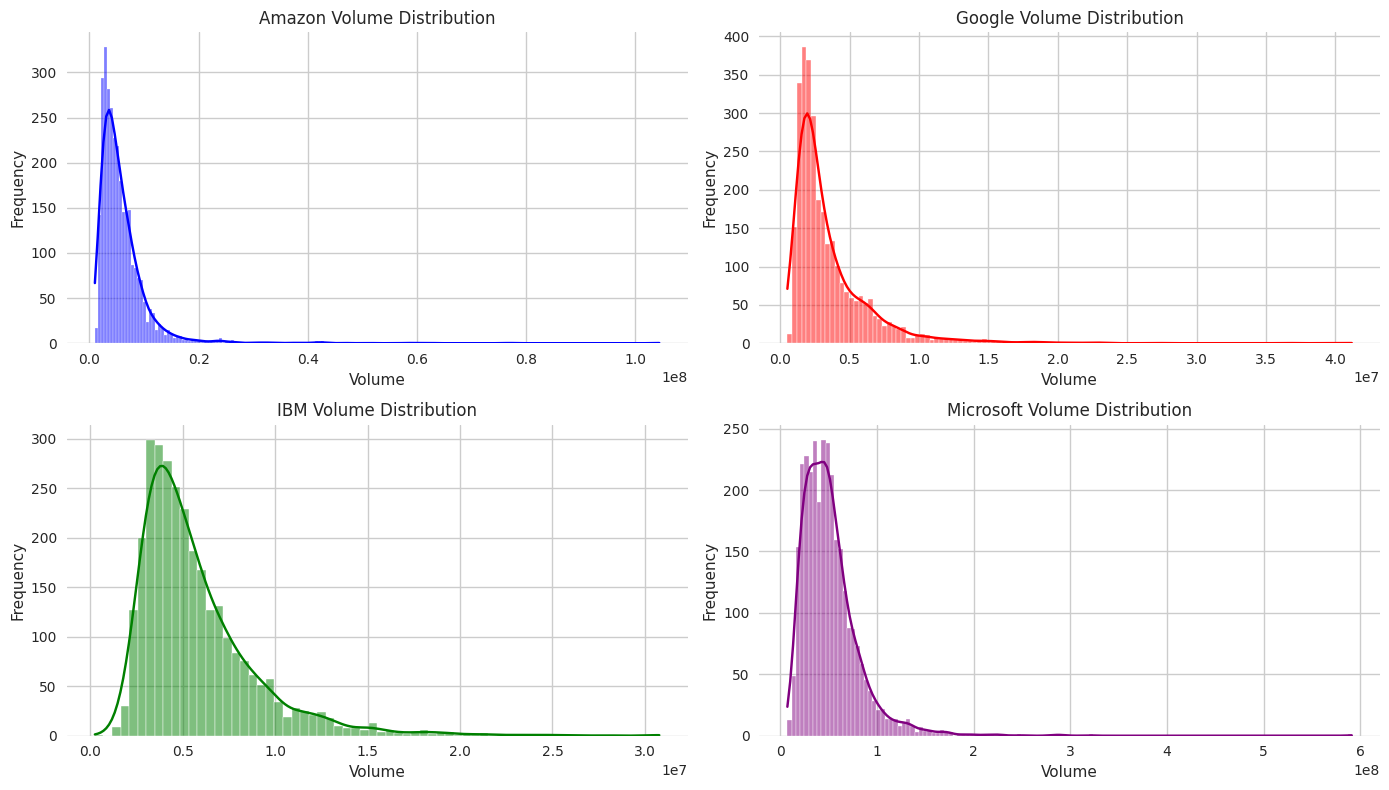

In [6]:
# Frequency distribution of volumes

plt.figure(figsize=(14, 8))

# Create histograms for each company's volume
plt.subplot(2, 2, 1)
sns.histplot(stock_df['VolumeAMZN'], kde=True, color='blue')
plt.title('Amazon Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(stock_df['VolumeGOOGL'], kde=True, color='red')
plt.title('Google Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(stock_df['VolumeIBM'], kde=True, color='green')
plt.title('IBM Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(stock_df['VolumeMSFT'], kde=True, color='purple')
plt.title('Microsoft Volume Distribution')
plt.xlabel('Volume')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

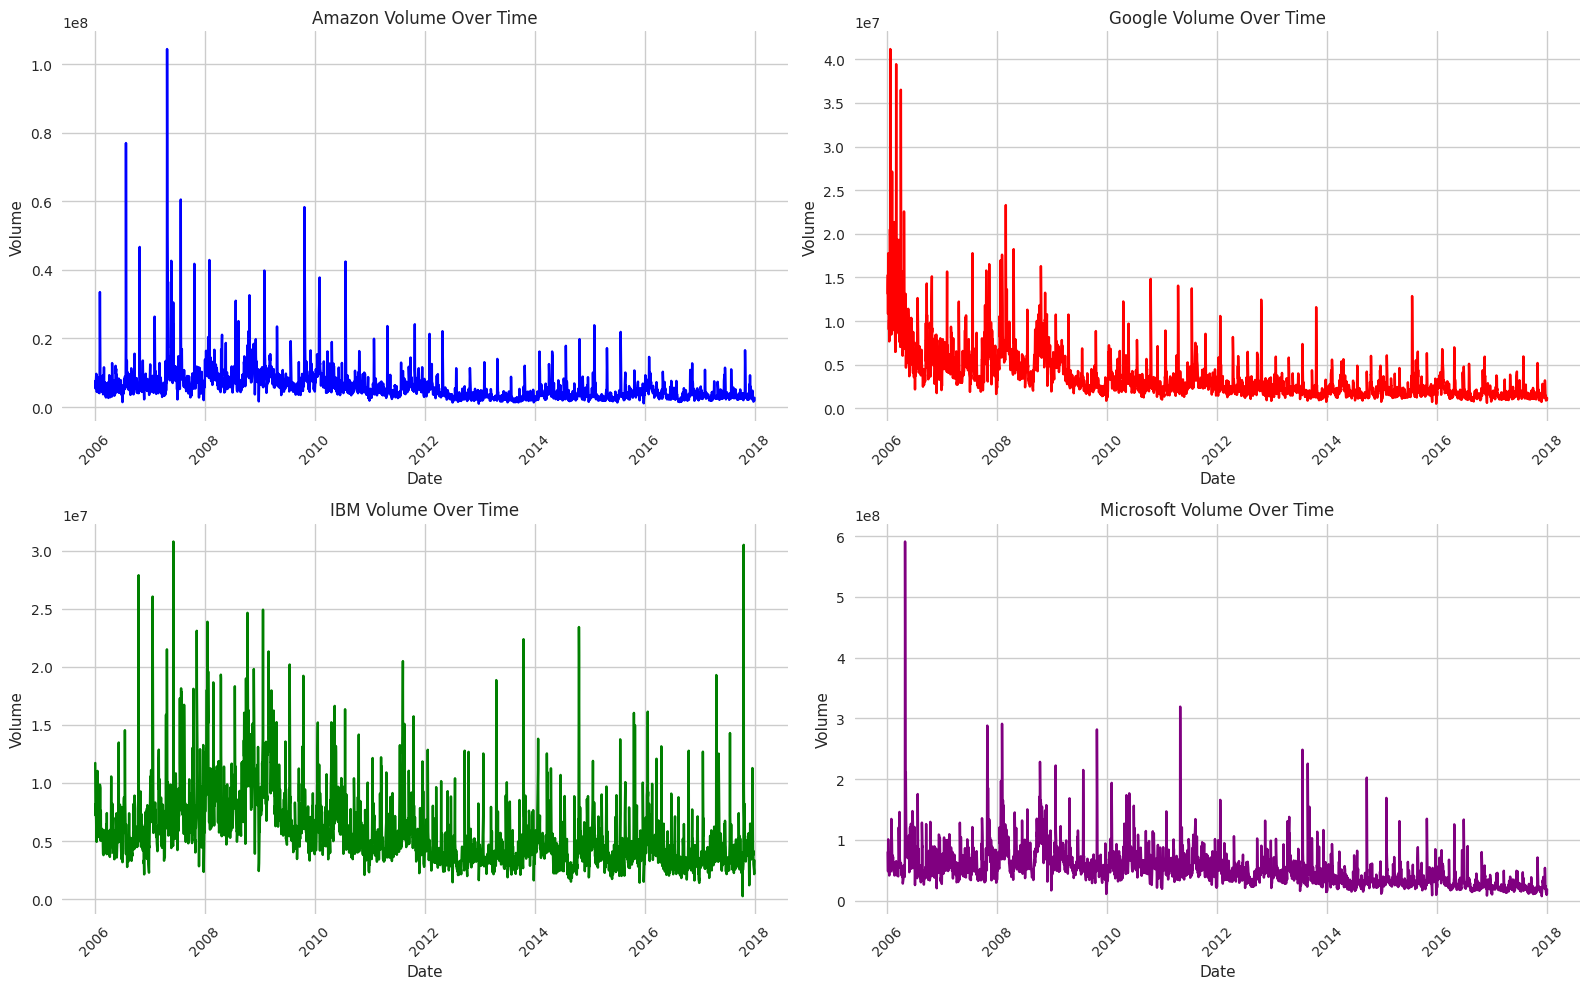

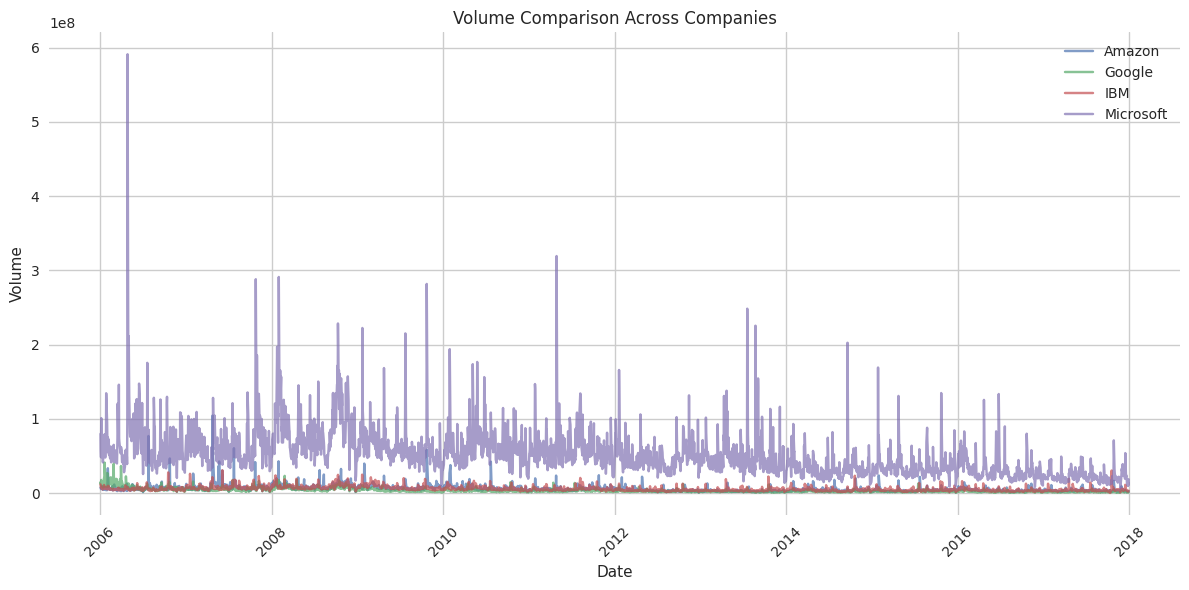

In [7]:


# Stock volume variation over time
plt.figure(figsize=(16, 10))

# Create line plots for each company's volume over time
plt.subplot(2, 2, 1)
plt.plot(stock_df['Date'], stock_df['VolumeAMZN'], color='blue')
plt.title('Amazon Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
plt.plot(stock_df['Date'], stock_df['VolumeGOOGL'], color='red')
plt.title('Google Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.plot(stock_df['Date'], stock_df['VolumeIBM'], color='green')
plt.title('IBM Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.plot(stock_df['Date'], stock_df['VolumeMSFT'], color='purple')
plt.title('Microsoft Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plot all volumes on the same graph for comparison
plt.figure(figsize=(12, 6))
plt.plot(stock_df['Date'], stock_df['VolumeAMZN'], label='Amazon', alpha=0.7)
plt.plot(stock_df['Date'], stock_df['VolumeGOOGL'], label='Google', alpha=0.7)
plt.plot(stock_df['Date'], stock_df['VolumeIBM'], label='IBM', alpha=0.7)
plt.plot(stock_df['Date'], stock_df['VolumeMSFT'], label='Microsoft', alpha=0.7)
plt.title('Volume Comparison Across Companies')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

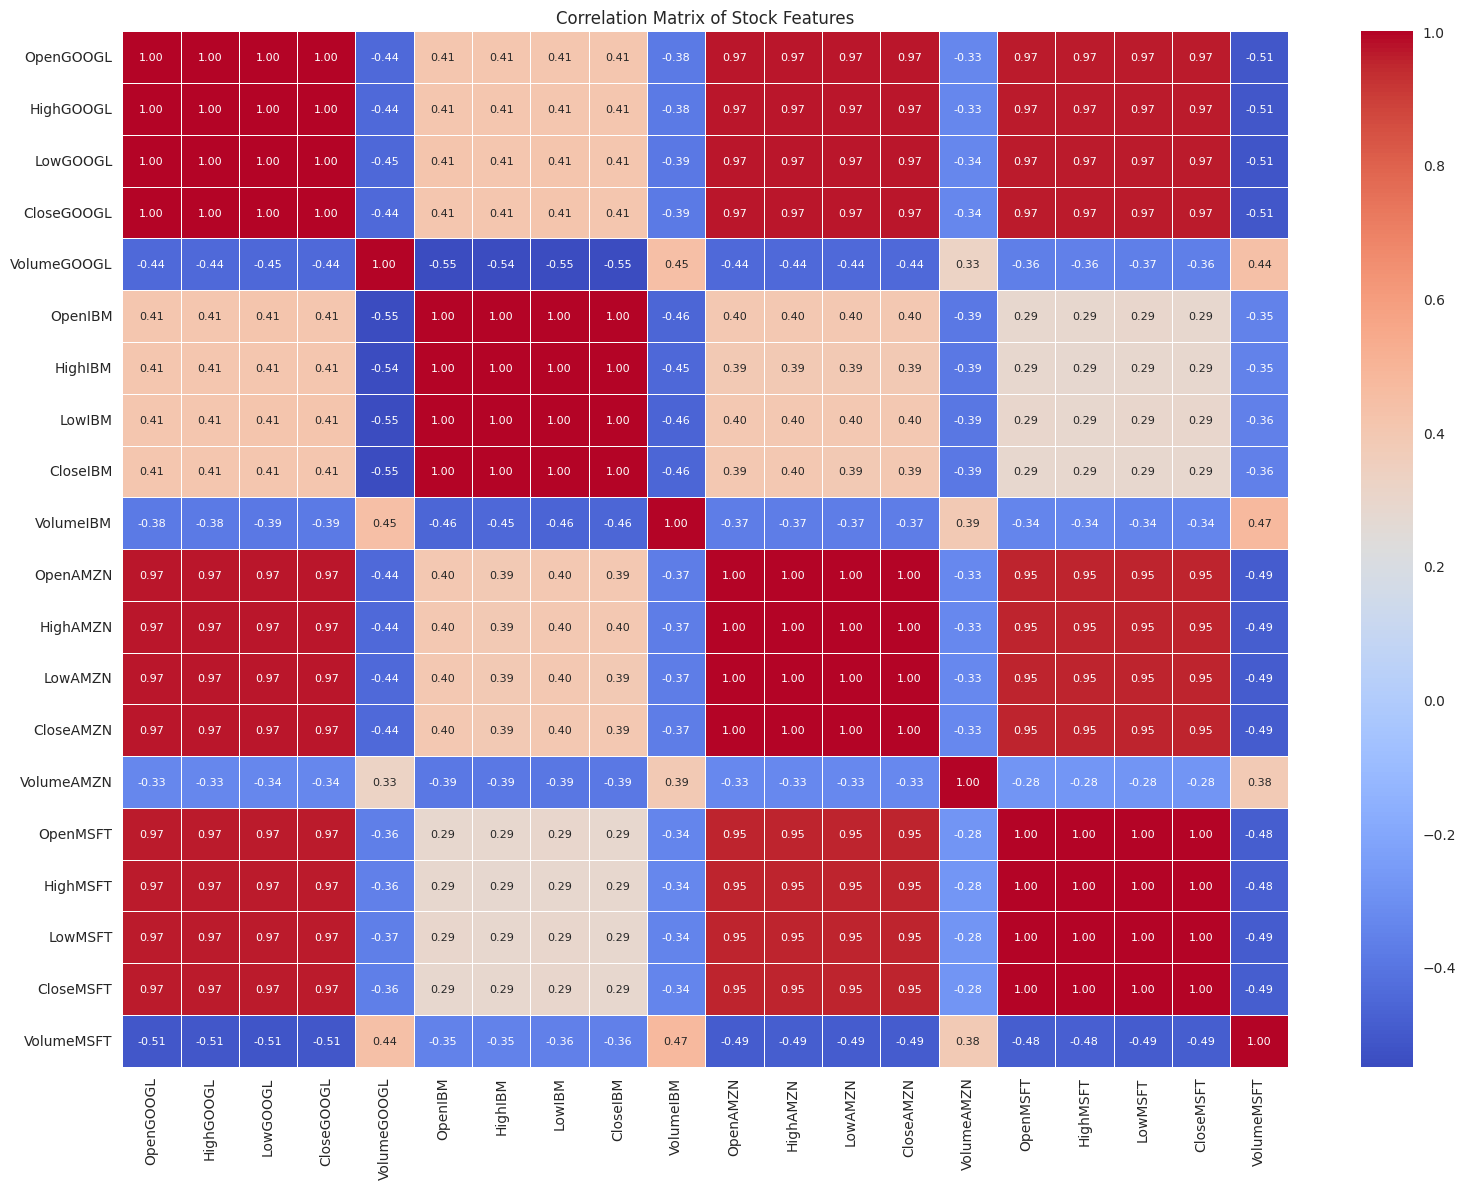

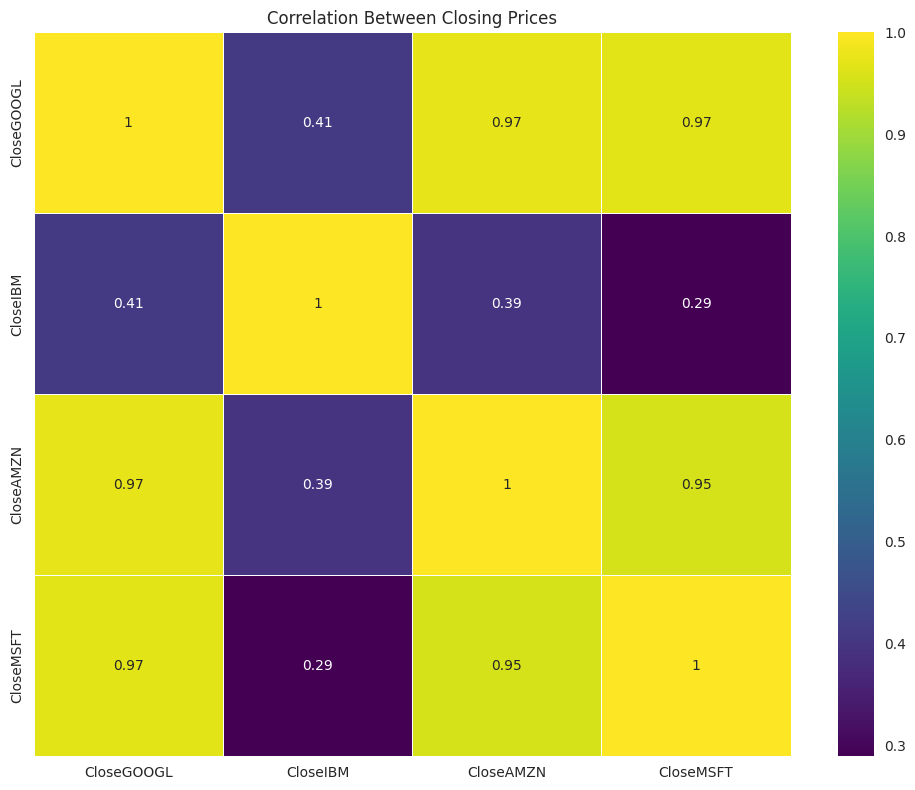

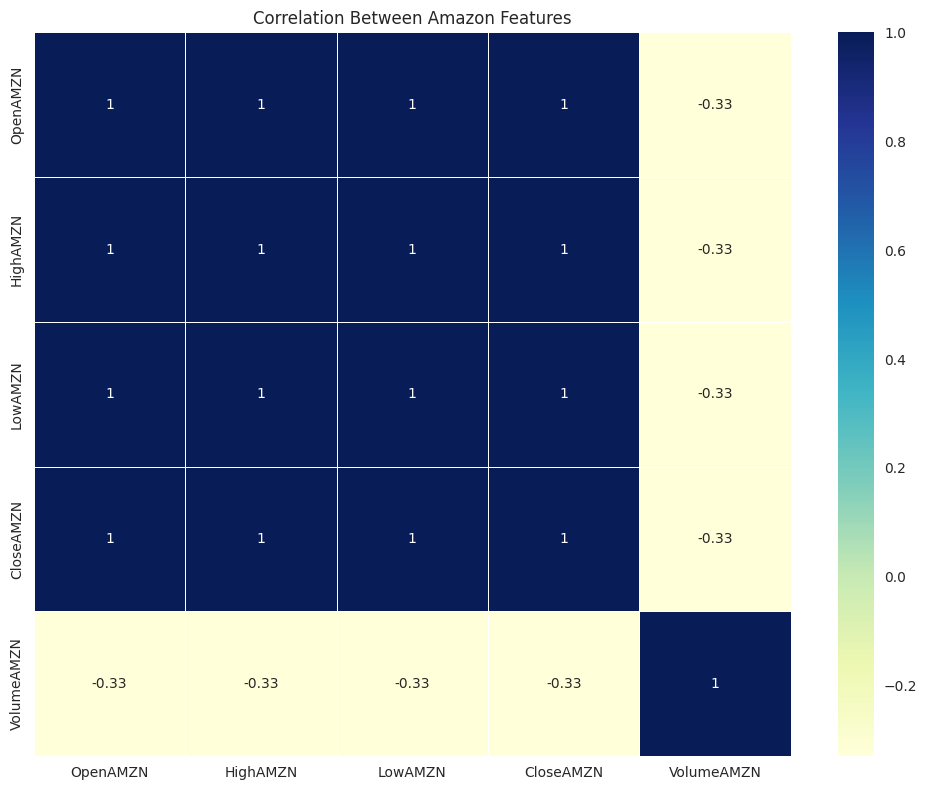

In [8]:

# Analyse correlations
# Create correlation matrix
correlation_matrix = stock_df.select_dtypes(include=[np.number]).corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', annot_kws={"size": 8})
plt.title('Correlation Matrix of Stock Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Focus on correlations between closing prices of different stocks
close_columns = [col for col in stock_df.columns if 'Close' in col]
close_correlation = stock_df[close_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(close_correlation, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Between Closing Prices')
plt.tight_layout()
plt.show()

# Analyze correlations between features for a single stock (e.g., Amazon)
amazon_features = [col for col in stock_df.columns if 'AMZN' in col]
amazon_correlation = stock_df[amazon_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(amazon_correlation, annot=True, cmap='YlGnBu', linewidths=0.5)
plt.title('Correlation Between Amazon Features')
plt.tight_layout()
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [9]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windows(df, window_size, step_size, target_names):
    """
    Creates windowed data from the input DataFrame.

    Parameters:
    - df: Input DataFrame
    - window_size: Size of the window (number of time steps)
    - step_size: Step size (stride) for creating windows
    - target_names: List of column names to predict

    Returns:
    - X_windows: List of DataFrames containing windowed features
    - y_values: Array of target values corresponding to each window
    """
    # Drop the Date column for windowing
    data = df.drop('Date', axis=1)

    # Initialize empty lists to store windows and target values
    X_windows = []
    y_values = []

    # Create windows with the specified window size and step size
    for i in range(0, len(data) - window_size, step_size):
        # Get the window data
        window = data.iloc[i:i + window_size]

        # Only create a window if we have the next data point for target
        if i + window_size < len(data):
            # Store the window as X
            X_windows.append(window)

            # Get target values (closing prices) for the next time step after the window
            target_vals = data.iloc[i + window_size][target_names].values
            y_values.append(target_vals)

    # Convert y_values to numpy array
    y_values = np.array(y_values)

    return X_windows, y_values


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [10]:

# Define a function that scales the windowed data
def scale_windows(X_train_windows, X_test_windows, y_train, y_test):
    """
    Scales the windowed data using MinMaxScaler.

    Parameters:
    - X_train_windows: List of DataFrames containing training windows
    - X_test_windows: List of DataFrames containing testing windows
    - y_train: Array of training target values
    - y_test: Array of testing target values

    Returns:
    - X_train_scaled: Scaled training windows
    - X_test_scaled: Scaled testing windows
    - y_train_scaled: Scaled training target values
    - y_test_scaled: Scaled testing target values
    - scalers: Dictionary of fitted scalers for inverse transformation
    """
    # Initialize scalers
    X_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(0, 1))

    # Create empty lists for scaled data
    X_train_scaled = []
    X_test_scaled = []

    # Concatenate all windows to fit the scaler
    # This is one approach to avoid data leakage - fit on training data only
    all_train_data = pd.concat(X_train_windows)
    X_scaler.fit(all_train_data)

    # Scale X_train windows
    for window in X_train_windows:
        scaled_window = X_scaler.transform(window)
        X_train_scaled.append(scaled_window)

    # Scale X_test windows
    for window in X_test_windows:
        scaled_window = X_scaler.transform(window)
        X_test_scaled.append(scaled_window)

    # Reshape y_train and y_test for scaling
    y_train_reshaped = y_train.reshape(-1, y_train.shape[1])
    y_test_reshaped = y_test.reshape(-1, y_test.shape[1])

    # Fit and transform y data
    y_scaler.fit(y_train_reshaped)
    y_train_scaled = y_scaler.transform(y_train_reshaped)
    y_test_scaled = y_scaler.transform(y_test_reshaped)

    # Convert lists to numpy arrays for X data
    X_train_scaled = np.array(X_train_scaled)
    X_test_scaled = np.array(X_test_scaled)

    # Store scalers for inverse transformation later
    scalers = {
        'X_scaler': X_scaler,
        'y_scaler': y_scaler
    }

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scalers


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [11]:
# Define a function to create input and output data points from the master DataFrame
def prepare_data(df, target_names, window_size, step_size, test_split=0.2):
    """
    Prepares data for RNN models by creating windows, splitting into training and testing sets,
    and scaling the data.

    Parameters:
    - df: Input DataFrame
    - target_names: List of column names to predict
    - window_size: Size of the window (number of time steps)
    - step_size: Step size (stride) for creating windows
    - test_split: Fraction of data to be used for testing

    Returns:
    - X_train_scaled: Scaled training features
    - X_test_scaled: Scaled testing features
    - y_train_scaled: Scaled training targets
    - y_test_scaled: Scaled testing targets
    - scalers: Dictionary of fitted scalers
    """
    # Create windows
    X_windows, y_values = create_windows(df, window_size, step_size, target_names)

    # Get the number of samples for training
    n_samples = len(X_windows)
    train_size = int(n_samples * (1 - test_split))

    # Split into training and testing sets
    X_train_windows = X_windows[:train_size]
    X_test_windows = X_windows[train_size:]
    y_train = y_values[:train_size]
    y_test = y_values[train_size:]

    # Scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scalers = scale_windows(
        X_train_windows, X_test_windows, y_train, y_test
    )

    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
    print(f"y_train_scaled shape: {y_train_scaled.shape}")
    print(f"y_test_scaled shape: {y_test_scaled.shape}")

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scalers




We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

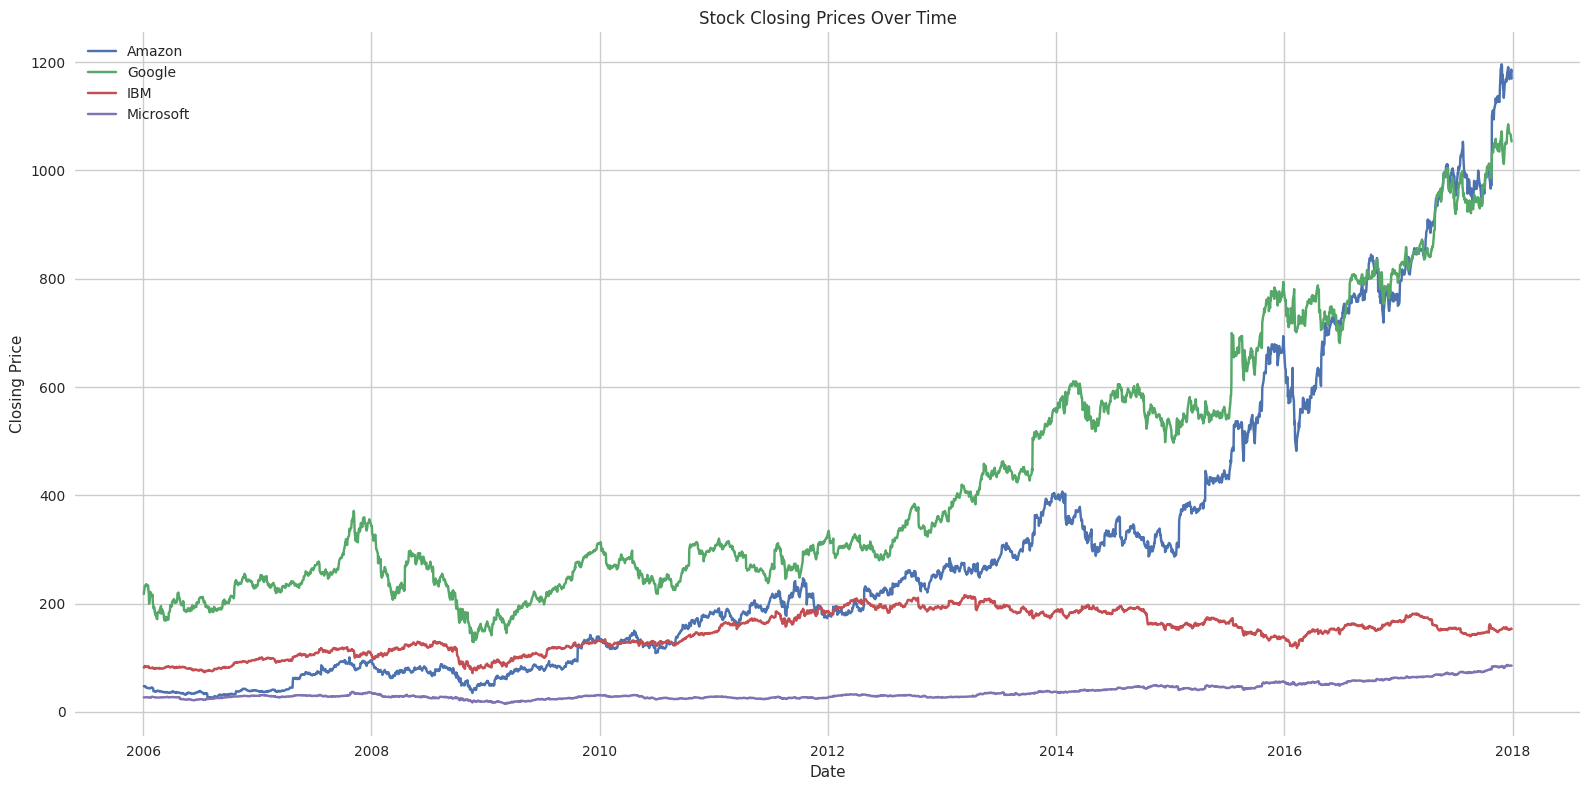

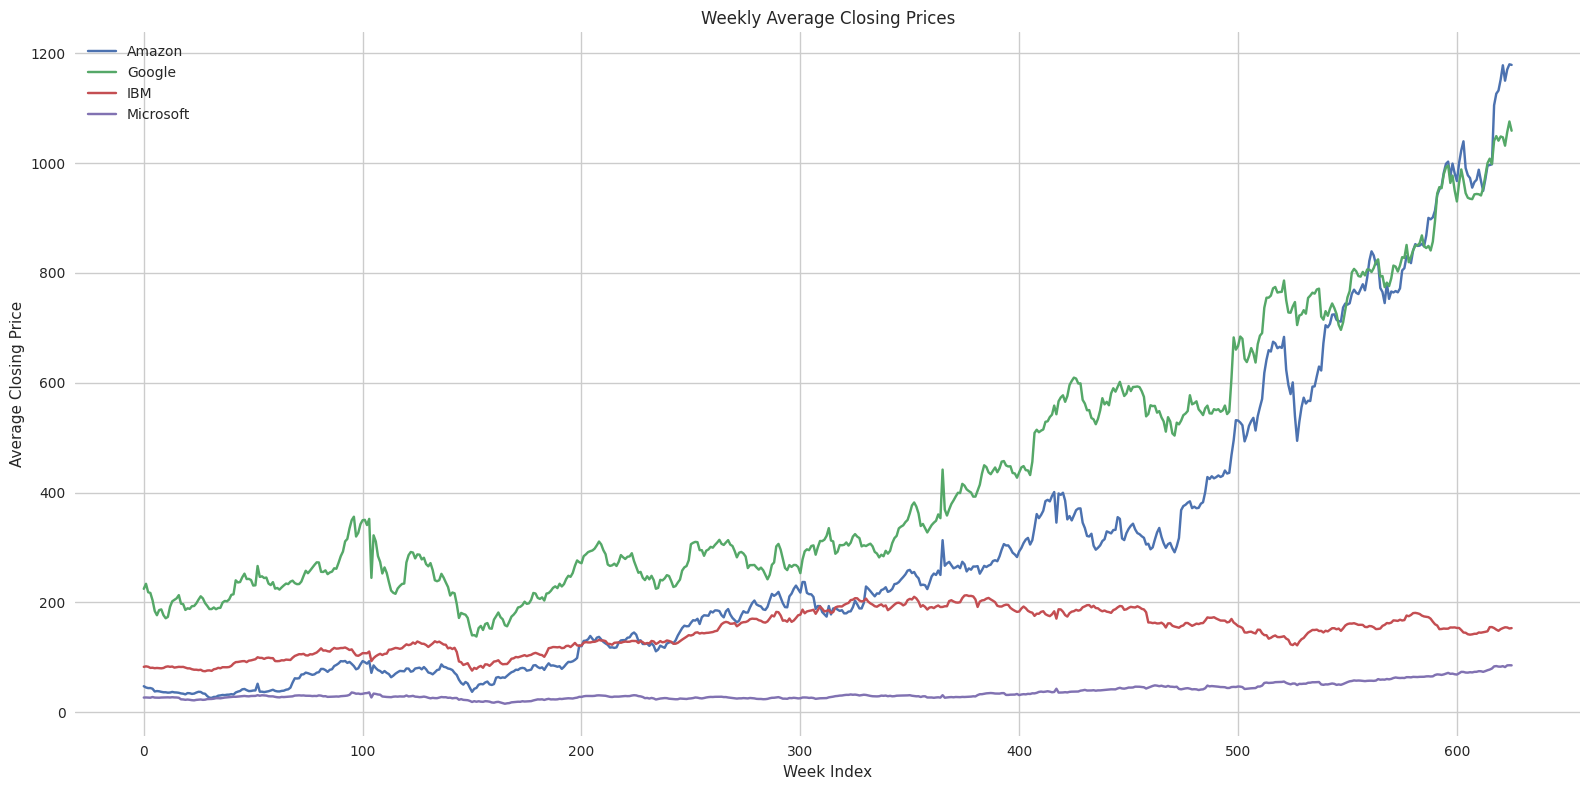

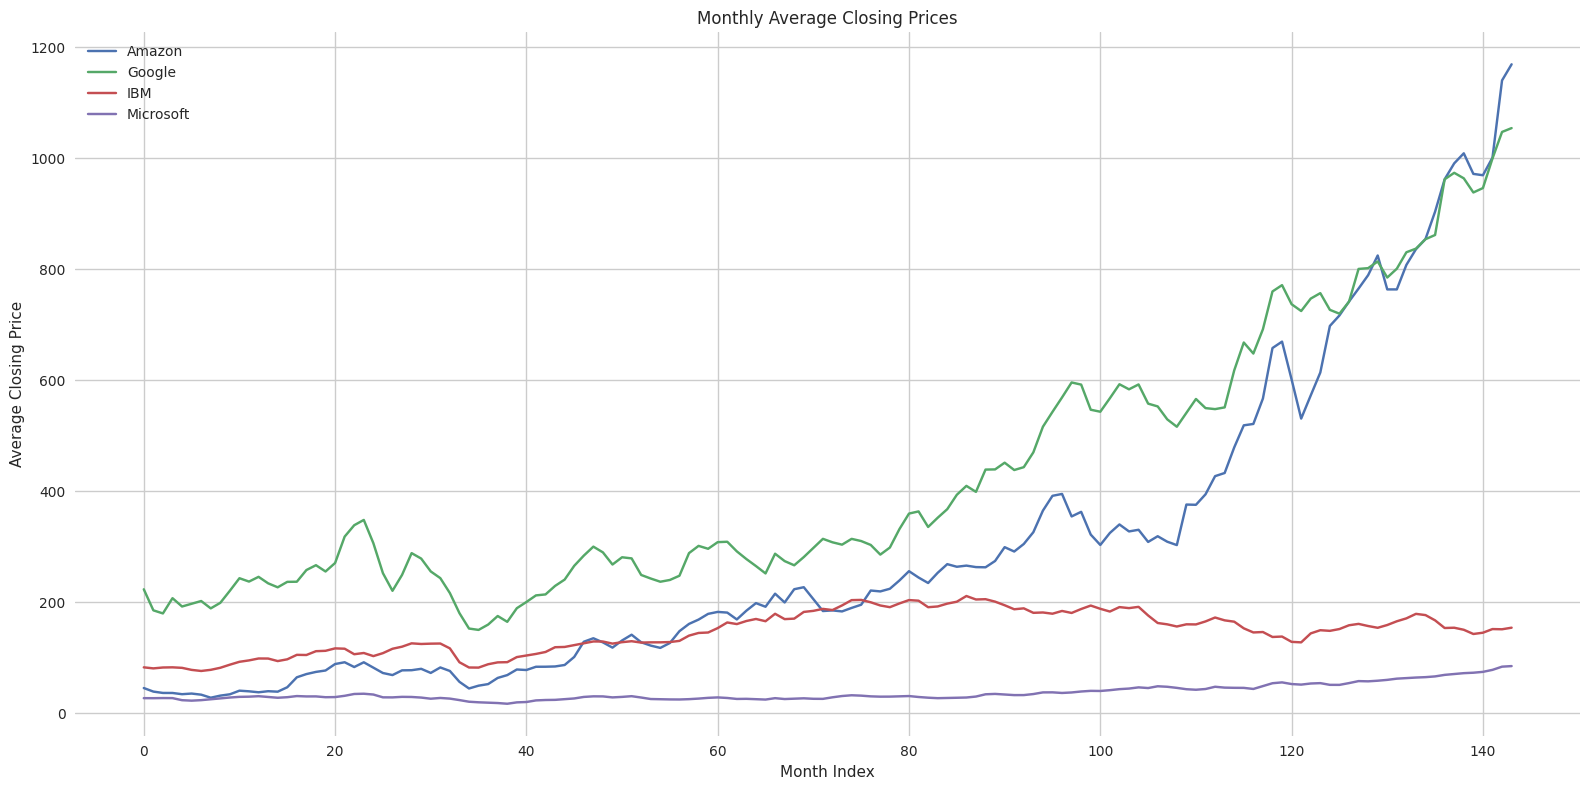

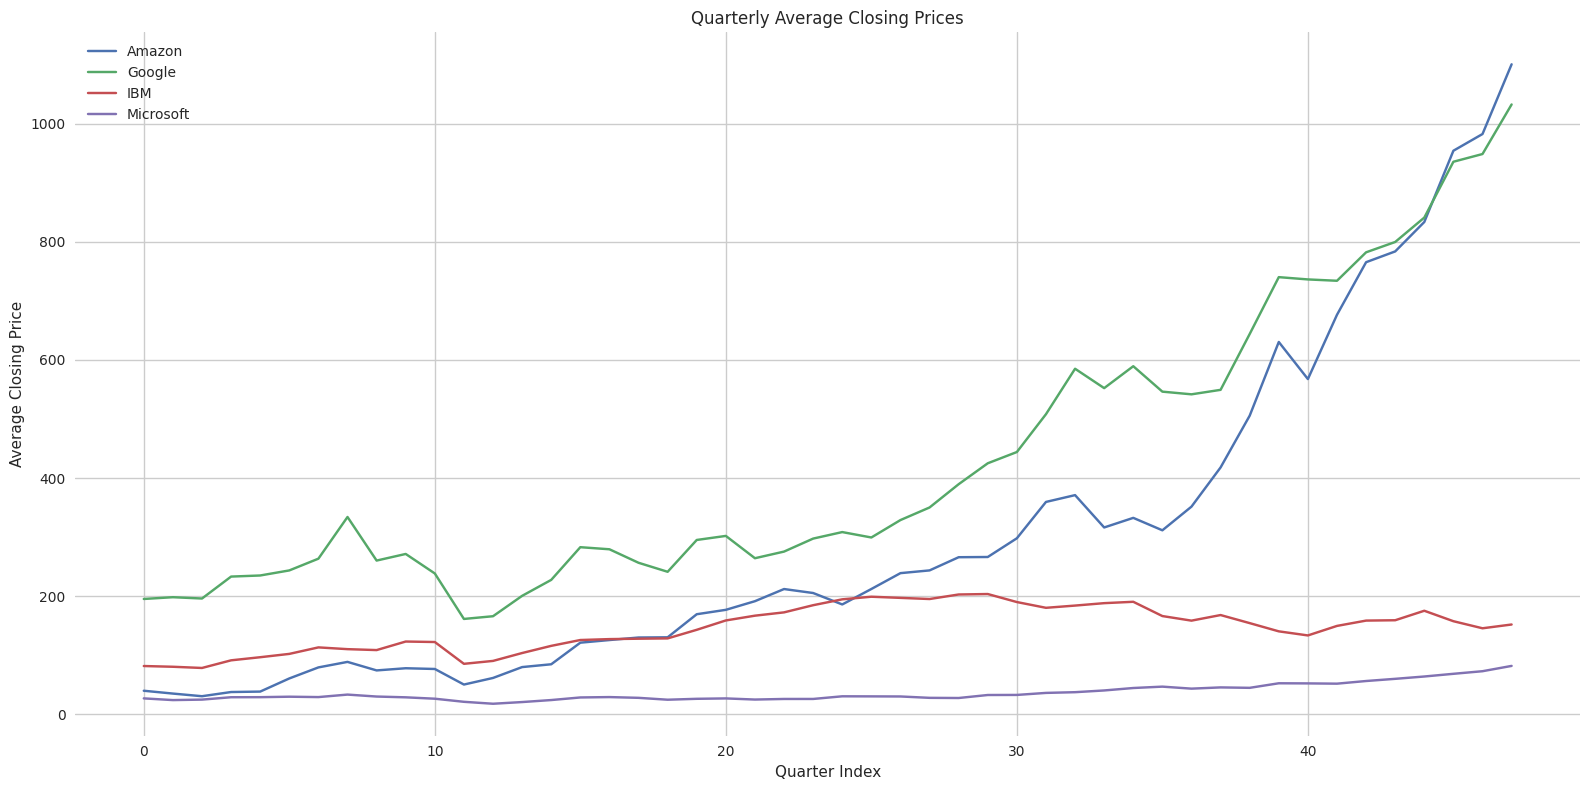

Based on the analysis of patterns, a window size of 20 days (approximately 1 business month) is chosen.


In [12]:

# Checking for patterns in different sequence lengths
# Plot the closing prices of all stocks
plt.figure(figsize=(16, 8))
plt.plot(stock_df['Date'], stock_df['CloseAMZN'], label='Amazon')
plt.plot(stock_df['Date'], stock_df['CloseGOOGL'], label='Google')
plt.plot(stock_df['Date'], stock_df['CloseIBM'], label='IBM')
plt.plot(stock_df['Date'], stock_df['CloseMSFT'], label='Microsoft')
plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create weekly averages to look for weekly patterns
stock_df['Week'] = stock_df['Date'].dt.isocalendar().week
stock_df['Year'] = stock_df['Date'].dt.year

weekly_avg = stock_df.groupby(['Year', 'Week']).mean().reset_index()

plt.figure(figsize=(16, 8))
plt.plot(range(len(weekly_avg)), weekly_avg['CloseAMZN'], label='Amazon')
plt.plot(range(len(weekly_avg)), weekly_avg['CloseGOOGL'], label='Google')
plt.plot(range(len(weekly_avg)), weekly_avg['CloseIBM'], label='IBM')
plt.plot(range(len(weekly_avg)), weekly_avg['CloseMSFT'], label='Microsoft')
plt.title('Weekly Average Closing Prices')
plt.xlabel('Week Index')
plt.ylabel('Average Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create monthly averages to look for monthly patterns
stock_df['Month'] = stock_df['Date'].dt.month
monthly_avg = stock_df.groupby(['Year', 'Month']).mean().reset_index()

plt.figure(figsize=(16, 8))
plt.plot(range(len(monthly_avg)), monthly_avg['CloseAMZN'], label='Amazon')
plt.plot(range(len(monthly_avg)), monthly_avg['CloseGOOGL'], label='Google')
plt.plot(range(len(monthly_avg)), monthly_avg['CloseIBM'], label='IBM')
plt.plot(range(len(monthly_avg)), monthly_avg['CloseMSFT'], label='Microsoft')
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month Index')
plt.ylabel('Average Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create quarterly averages to look for quarterly patterns
stock_df['Quarter'] = stock_df['Date'].dt.quarter
quarterly_avg = stock_df.groupby(['Year', 'Quarter']).mean().reset_index()

plt.figure(figsize=(16, 8))
plt.plot(range(len(quarterly_avg)), quarterly_avg['CloseAMZN'], label='Amazon')
plt.plot(range(len(quarterly_avg)), quarterly_avg['CloseGOOGL'], label='Google')
plt.plot(range(len(quarterly_avg)), quarterly_avg['CloseIBM'], label='IBM')
plt.plot(range(len(quarterly_avg)), quarterly_avg['CloseMSFT'], label='Microsoft')
plt.title('Quarterly Average Closing Prices')
plt.xlabel('Quarter Index')
plt.ylabel('Average Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Based on the analysis, we'll use a window size of 90 days (approximately 3 business month)
# This seems to be a good compromise between capturing short-term trends and having enough data points
print("Based on the analysis of patterns, a window size of 90 days (approximately 3 business month) is chosen.")
window_size = 90
step_size = 1  # We'll use a step size of 1 for maximum data utilization


 ## Choice of Optimal Window Size

 After training and evaluating models on different window sizes (20, 30, 60, and 90), the model with a 90-day window consistently achieved the best performance across key metrics such as R² score, MAE, and RMSE. This indicates that the 90-day window provides the model with enough historical context to make more informed and stable predictions.”

*Tested window sizes: 20, 30, 60, and 90 days*  
*20 days*: Captures short-term trends but lacks context for stable predictions  
*30 & 60 days*: Slightly better, but still limited predictive strength  
*90 days*: Best performance with improved accuracy and stability

*90-day window chosen as the optimal setting for modeling as it gives best performance.*  
Although multiple window sizes (20, 30, 60, 90 days) were tested, the 90-day window consistently outperformed others in predictive accuracy and stability. It offers a good balance between trend visibility and noise reduction, making it the most suitable choice for our modeling objectives.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [13]:
# Create data instances from the master data frame using decided window size and window stride
# Define the target stock for prediction (Amazon closing price)
target_names = ['CloseAMZN']  # We'll focus on predicting Amazon's closing price

# Prepare the data with the chosen window size and step size
X_train, X_test, y_train, y_test, scalers = prepare_data(
    stock_df,
    target_names,
    window_size=window_size,
    step_size=step_size,
    test_split=0.2
)

# Check the number of data points generated
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

X_train_scaled shape: (2344, 90, 24)
X_test_scaled shape: (586, 90, 24)
y_train_scaled shape: (2344, 1)
y_test_scaled shape: (586, 1)
Number of training samples: 2344
Number of testing samples: 586


In [14]:
# Check the number of data points generated

print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")


Number of training samples: 2344
Number of testing samples: 586


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [15]:
# Check if the datasets are compatible inputs to neural networks

print("Data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check data types
print("\nData types:")
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")

# Ensure data is in float32 format for TensorFlow
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print("\nAfter conversion to float32:")
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")

# Print example data points
print("\nExample data point (first window in X_train):")
print(X_train[0][:5, :5])  # Print first 5 rows and 5 columns of first window

print("\nExample target value (first target in y_train):")
print(y_train[0])

# Verify RNN compatibility
print("\nVerifying RNN input compatibility:")
print(f"Time steps (window size): {X_train.shape[1]}")
print(f"Features per time step: {X_train.shape[2]}")
print(f"Target dimensions: {y_train.shape[1]}")

Data shapes:
X_train shape: (2344, 90, 24)
X_test shape: (586, 90, 24)
y_train shape: (2344, 1)
y_test shape: (586, 1)

Data types:
X_train dtype: float64
y_train dtype: float64

After conversion to float32:
X_train dtype: float32
y_train dtype: float32

Example data point (first window in X_train):
[[0.14093877 0.1438696  0.15065598 0.15589467 0.3066421 ]
 [0.1597705  0.15536465 0.16962226 0.16467229 0.35991704]
 [0.16161847 0.1576118  0.17117196 0.16994587 0.24924129]
 [0.17119274 0.17401601 0.18152681 0.18257792 0.420912  ]
 [0.17960541 0.17652245 0.18830676 0.18366417 0.29819652]]

Example target value (first target in y_train):
[0.0130348]

Verifying RNN input compatibility:
Time steps (window size): 90
Features per time step: 24
Target dimensions: 1


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [16]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(input_shape, output_dim, units=64, dropout_rate=0.2,
                           learning_rate=0.001, hidden_layers=1, activation='tanh'):
    """
    Creates a simple RNN model with the specified configuration.

    Parameters:
    - input_shape: Shape of input data (time_steps, features)
    - output_dim: Dimension of output (number of target variables)
    - units: Number of units in each RNN layer
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for the optimizer
    - hidden_layers: Number of hidden RNN layers
    - activation: Activation function for the RNN layers

    Returns:
    - model: Compiled Keras model
    """
    model = Sequential()

    # Add RNN layers
    if hidden_layers == 1:
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           input_shape=input_shape,
                           return_sequences=False))
        model.add(Dropout(dropout_rate))
    else:
        # First layer
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           input_shape=input_shape,
                           return_sequences=True))
        model.add(Dropout(dropout_rate))

        # Hidden layers
        for i in range(hidden_layers - 2):
            model.add(SimpleRNN(units=units,
                               activation=activation,
                               return_sequences=True))
            model.add(Dropout(dropout_rate))

        # Last RNN layer
        model.add(SimpleRNN(units=units,
                           activation=activation,
                           return_sequences=False))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [17]:
# Find an optimal configuration of simple RNN
# Define hyperparameter values to test
hidden_layers_options = [1, 2]
units_options = [32, 64, 128]
dropout_rate_options = [0.2, 0.3]
learning_rate_options = [0.001, 0.01]
activation_options = ['tanh', 'relu']

# Define input shape and output dimension
input_shape = (X_train.shape[1], X_train.shape[2])
output_dim = y_train.shape[1]

# Create a list to store results
results = []

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Loop through hyperparameter combinations
for hidden_layers in hidden_layers_options:
    for units in units_options:
        for dropout_rate in dropout_rate_options:
            for learning_rate in learning_rate_options:
                for activation in activation_options:
                    print(f"Training with: hidden_layers={hidden_layers}, units={units}, dropout={dropout_rate}, "
                          f"learning_rate={learning_rate}, activation={activation}")

                    # Create the model with the current configuration
                    model = create_simple_rnn_model(
                        input_shape=input_shape,
                        output_dim=output_dim,
                        units=units,
                        dropout_rate=dropout_rate,
                        learning_rate=learning_rate,
                        hidden_layers=hidden_layers,
                        activation=activation
                    )

                    # Train the model
                    history = model.fit(
                        X_train, y_train,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=0
                    )

                    # Evaluate on the test set
                    test_loss = model.evaluate(X_test, y_test, verbose=0)

                    # Store the results
                    results.append({
                        'hidden_layers': hidden_layers,
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate,
                        'activation': activation,
                        'val_loss': min(history.history['val_loss']),
                        'test_loss': test_loss,
                        'epochs': len(history.history['loss'])
                    })

                    # Clear memory
                    tf.keras.backend.clear_session()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)


Training with: hidden_layers=1, units=32, dropout=0.2, learning_rate=0.001, activation=tanh


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with: hidden_layers=1, units=32, dropout=0.2, learning_rate=0.001, activation=relu
Training with: hidden_layers=1, units=32, dropout=0.2, learning_rate=0.01, activation=tanh
Training with: hidden_layers=1, units=32, dropout=0.2, learning_rate=0.01, activation=relu
Training with: hidden_layers=1, units=32, dropout=0.3, learning_rate=0.001, activation=tanh
Training with: hidden_layers=1, units=32, dropout=0.3, learning_rate=0.001, activation=relu
Training with: hidden_layers=1, units=32, dropout=0.3, learning_rate=0.01, activation=tanh
Training with: hidden_layers=1, units=32, dropout=0.3, learning_rate=0.01, activation=relu
Training with: hidden_layers=1, units=64, dropout=0.2, learning_rate=0.001, activation=tanh
Training with: hidden_layers=1, units=64, dropout=0.2, learning_rate=0.001, activation=relu
Training with: hidden_layers=1, units=64, dropout=0.2, learning_rate=0.01, activation=tanh
Training with: hidden_layers=1, units=64, dropout=0.2, learning_rate=0.01, activation

Top 5 configurations by validation loss:
    hidden_layers  units  dropout_rate  learning_rate activation  val_loss  test_loss  epochs
2               1     32           0.2          0.010       tanh  0.000413   0.046677      23
17              1    128           0.2          0.001       relu  0.000471   0.010628      34
10              1     64           0.2          0.010       tanh  0.000484   0.061485      25
16              1    128           0.2          0.001       tanh  0.000550   0.061347      38
20              1    128           0.3          0.001       tanh  0.000557   0.053356      23

Best configuration:
hidden_layers: 1
units: 32
dropout_rate: 0.2
learning_rate: 0.01
activation: tanh
val_loss: 0.0004131805617362261
test_loss: 0.04667713865637779
epochs: 23


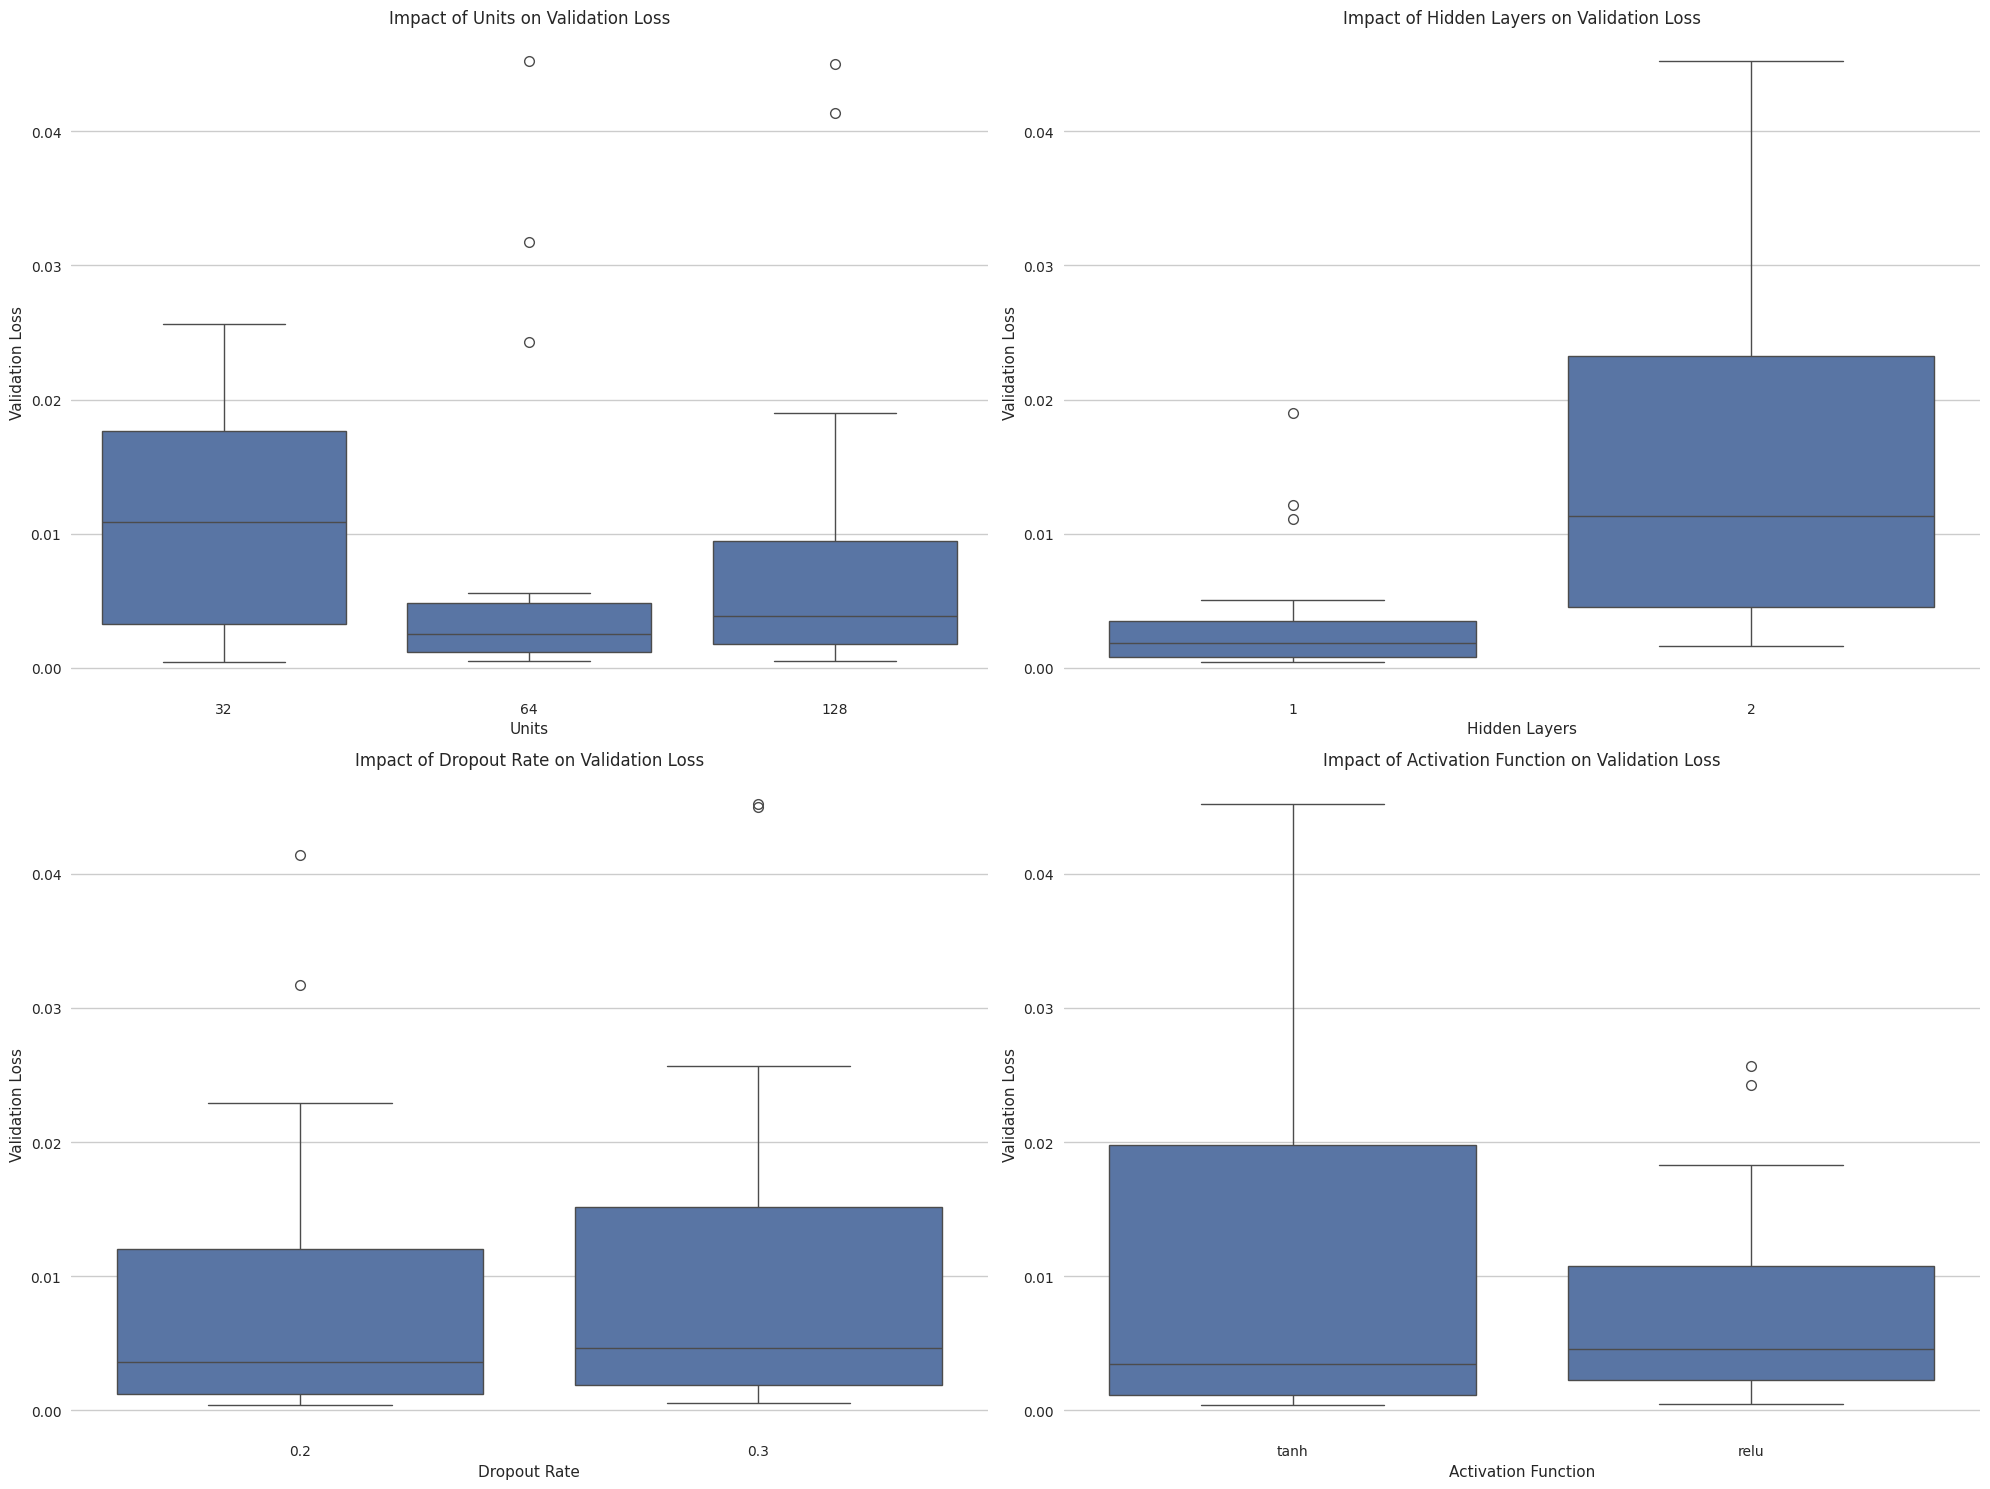

In [18]:
# Find the best configuration based on evaluation metrics
# Sort results by validation loss (ascending)
results_df_sorted = results_df.sort_values('val_loss')

# Print the top 5 configurations
print("Top 5 configurations by validation loss:")
print(results_df_sorted.head(5).to_string())

# Identify the best configuration
best_config = results_df_sorted.iloc[0]
print("\nBest configuration:")
for param, value in best_config.items():
    print(f"{param}: {value}")

# Visualize the impact of hyperparameters on validation loss
plt.figure(figsize=(20, 15))

# Plot of validation loss by units
plt.subplot(2, 2, 1)
sns.boxplot(x='units', y='val_loss', data=results_df)
plt.title('Impact of Units on Validation Loss')
plt.xlabel('Units')
plt.ylabel('Validation Loss')

# Plot of validation loss by hidden layers
plt.subplot(2, 2, 2)
sns.boxplot(x='hidden_layers', y='val_loss', data=results_df)
plt.title('Impact of Hidden Layers on Validation Loss')
plt.xlabel('Hidden Layers')
plt.ylabel('Validation Loss')

# Plot of validation loss by dropout rate
plt.subplot(2, 2, 3)
sns.boxplot(x='dropout_rate', y='val_loss', data=results_df)
plt.title('Impact of Dropout Rate on Validation Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Loss')

# Plot of validation loss by activation function
plt.subplot(2, 2, 4)
sns.boxplot(x='activation', y='val_loss', data=results_df)
plt.title('Impact of Activation Function on Validation Loss')
plt.xlabel('Activation Function')
plt.ylabel('Validation Loss')

plt.tight_layout()
plt.show()

# Capture the best hyperparameters for later use
best_hidden_layers = int(best_config['hidden_layers']) # Ensure hidden_layers is an integer
best_units = int(best_config['units']) # Ensure units is an integer
best_dropout_rate = best_config['dropout_rate']
best_learning_rate = best_config['learning_rate']
best_activation = best_config['activation']

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857 (7.25 KB)

 Trainable params: 1,857 (7.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.2209 - val_loss: 0.0315
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0116 - val_loss: 0.0196
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0047 - val_loss: 0.0128
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.7847e-04 - val_loss: 0.0013
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

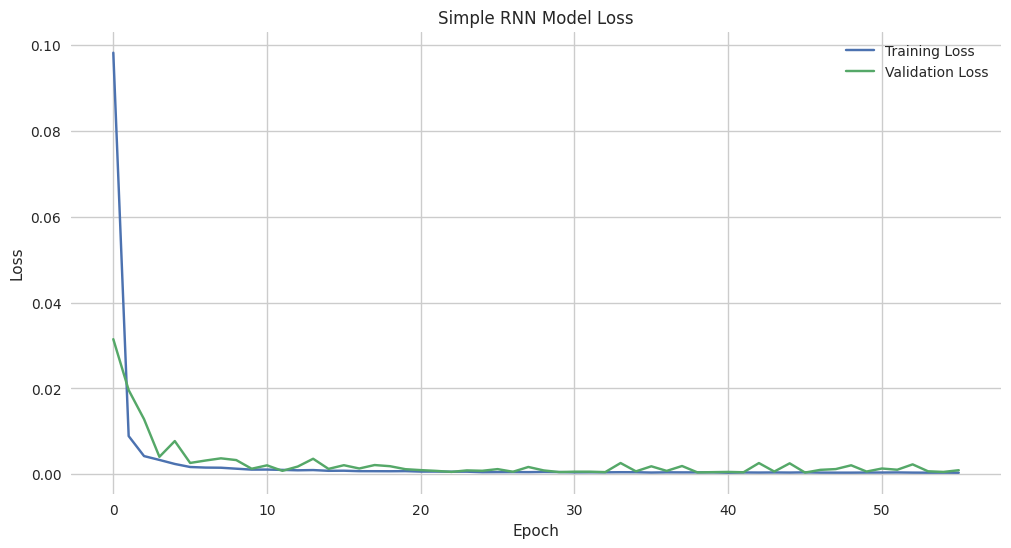

In [19]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

tf.keras.backend.clear_session()

# Create the model with best hyperparameters
best_simple_rnn_model = create_simple_rnn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    units=best_units,
    dropout_rate=best_dropout_rate,
    learning_rate=best_learning_rate,
    hidden_layers=best_hidden_layers,
    activation=best_activation
)

# Print model summary
best_simple_rnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with the optimal configuration
history = best_simple_rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
best_simple_rnn_model.save('best_simple_rnn_model.h5')


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


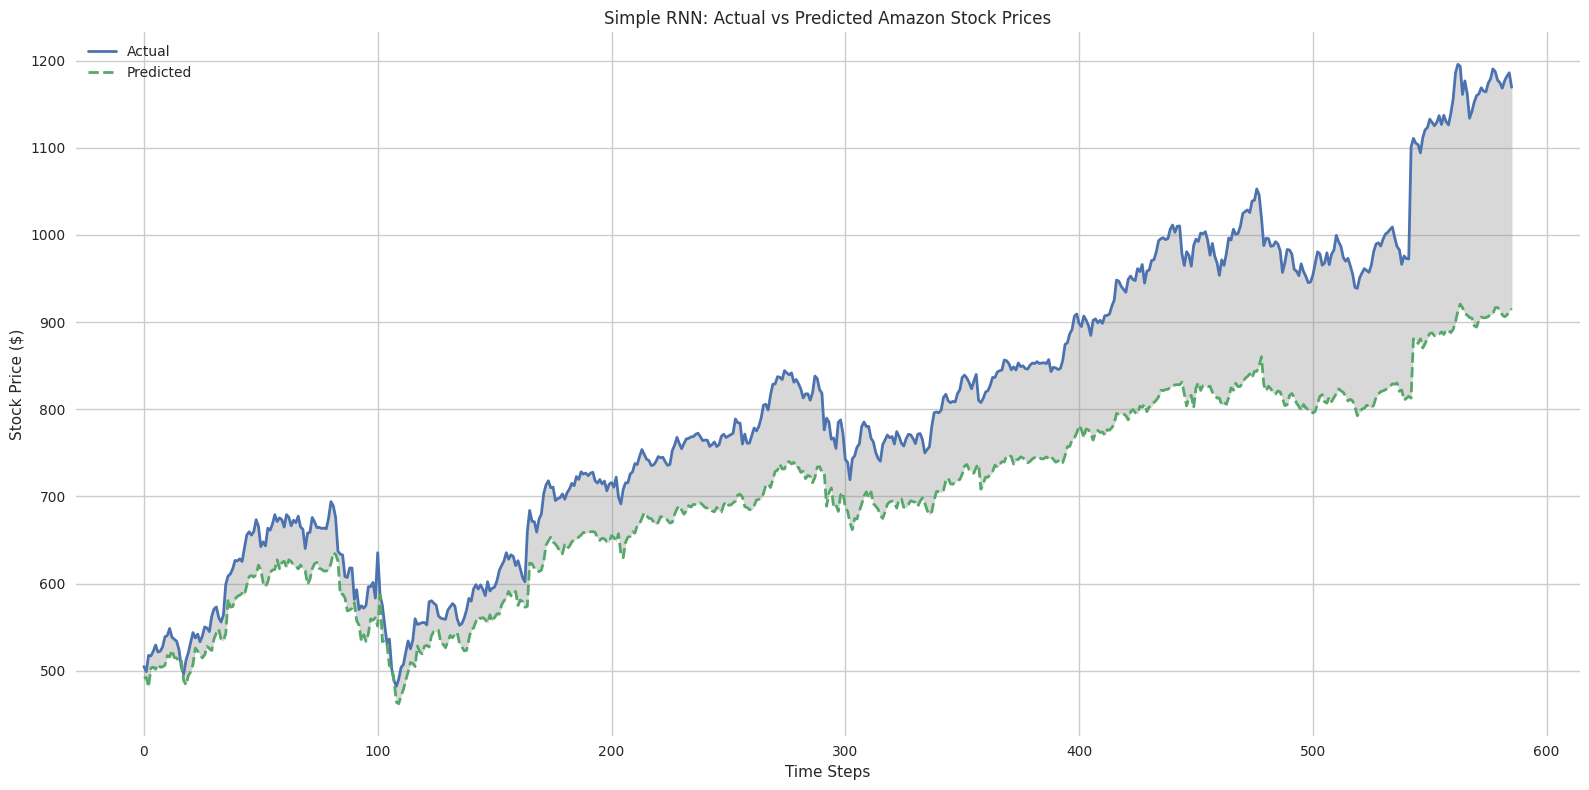

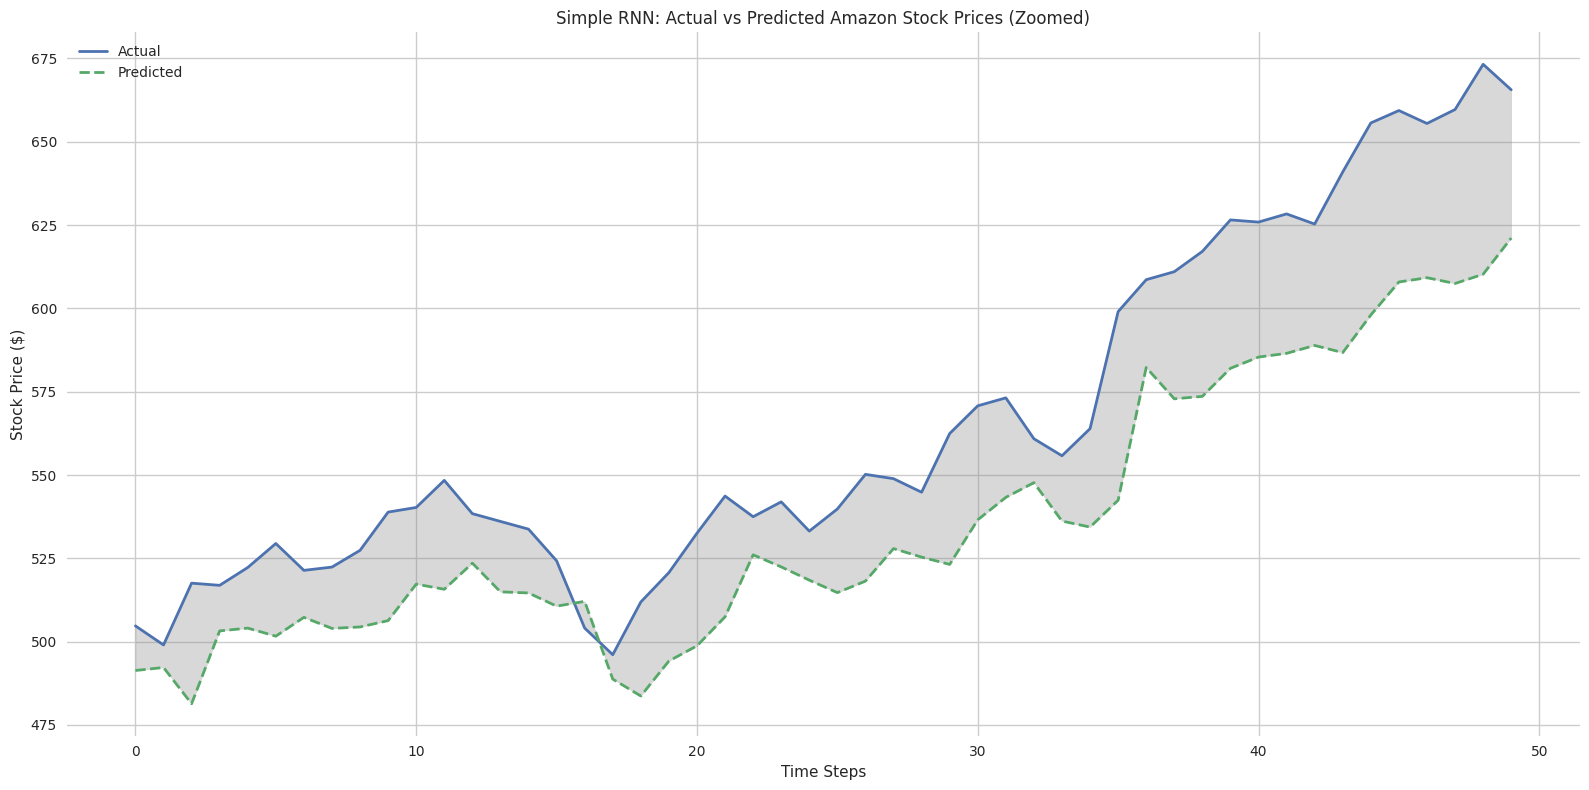

In [20]:
# Predict on the test data and plot
# Make predictions
y_pred_scaled = best_simple_rnn_model.predict(X_test)

# Inverse transform to get actual values
y_test_orig = scalers['y_scaler'].inverse_transform(y_test)
y_pred_orig = scalers['y_scaler'].inverse_transform(y_pred_scaled)

# Create time index for plotting
time_index = range(len(y_test_orig))

# Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(time_index, y_test_orig, label='Actual', linewidth=2)
plt.plot(time_index, y_pred_orig, label='Predicted', linewidth=2, linestyle='--')
plt.fill_between(time_index, y_test_orig.flatten(), y_pred_orig.flatten(), color='gray', alpha=0.3)
plt.title('Simple RNN: Actual vs Predicted Amazon Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoom in on a portion of the data for better visibility
zoom_start = 0
zoom_end = 50  # Show first 50 predictions
plt.figure(figsize=(16, 8))
plt.plot(time_index[zoom_start:zoom_end], y_test_orig[zoom_start:zoom_end], label='Actual', linewidth=2)
plt.plot(time_index[zoom_start:zoom_end], y_pred_orig[zoom_start:zoom_end], label='Predicted', linewidth=2, linestyle='--')
plt.fill_between(time_index[zoom_start:zoom_end], y_test_orig.flatten()[zoom_start:zoom_end], y_pred_orig.flatten()[zoom_start:zoom_end],
                 color='gray', alpha=0.3)
plt.title('Simple RNN: Actual vs Predicted Amazon Stock Prices (Zoomed)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

Performance metrics for Simple RNN model:
                               Metric        Value
             Mean Squared Error (MSE) 14646.641602
       Root Mean Squared Error (RMSE)   121.023310
            Mean Absolute Error (MAE)   101.792976
                             R² Score     0.525661
Mean Absolute Percentage Error (MAPE)    11.594797


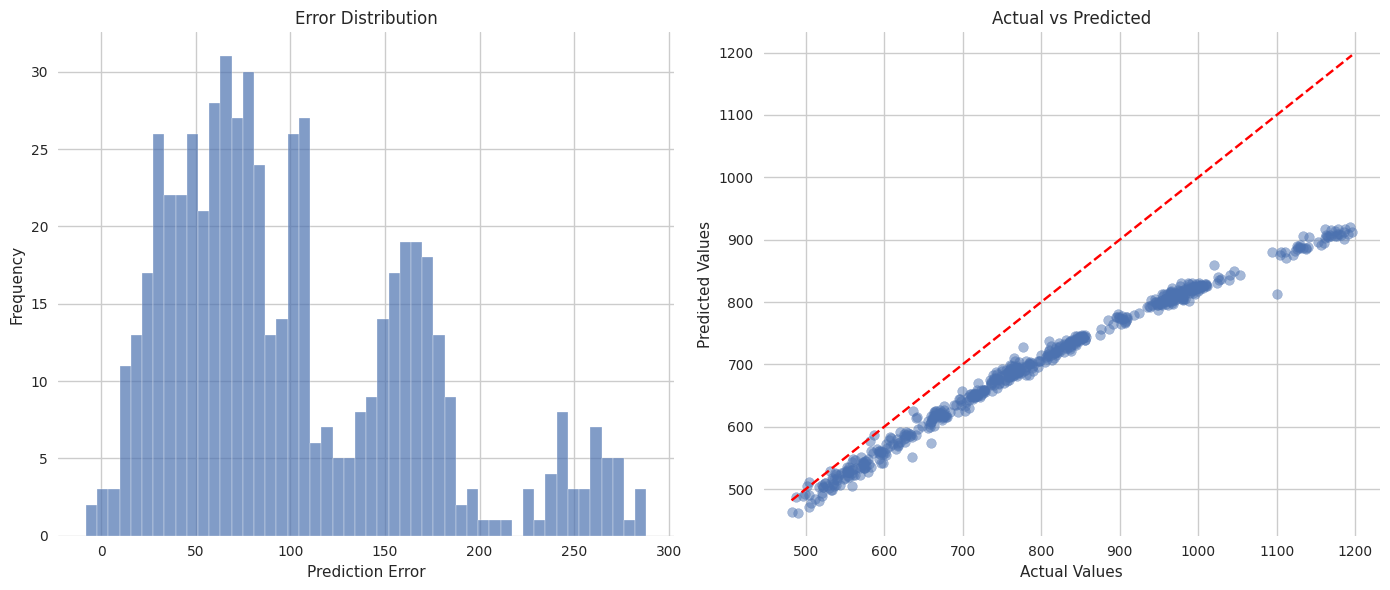


Simple RNN Model Performance Summary:
The model has an R² score of 0.5257, which means it explains 52.57% of the variance in the stock price.
The RMSE is $121.02, indicating the average prediction error in dollars.
The MAPE is 11.59%, which is the percentage error relative to the actual stock price.


In [21]:
# Compute the performance of the model on the testing data set
# Calculate various error metrics
mse = mean_squared_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)',
               'Mean Absolute Error (MAE)', 'R² Score', 'Mean Absolute Percentage Error (MAPE)'],
    'Value': [mse, rmse, mae, r2, mape]
})

# Print metrics
print("Performance metrics for Simple RNN model:")
print(metrics_df.to_string(index=False))

# Visualize the error distribution
errors = y_test_orig.flatten() - y_pred_orig.flatten()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print a summary of the model's performance
print("\nSimple RNN Model Performance Summary:")
print(f"The model has an R² score of {r2:.4f}, which means it explains {r2*100:.2f}% of the variance in the stock price.")
print(f"The RMSE is ${rmse:.2f}, indicating the average prediction error in dollars.")
print(f"The MAPE is {mape:.2f}%, which is the percentage error relative to the actual stock price.")


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [22]:
# Define a function to create a model and specify default values for hyperparameters
def create_advanced_rnn_model(input_shape, output_dim, model_type='LSTM', units=64,
                             dropout_rate=0.2, learning_rate=0.001, hidden_layers=1,
                             activation='tanh', bidirectional=False, regularization=None):
    """
    Creates an advanced RNN model (LSTM or GRU) with the specified configuration.

    Parameters:
    - input_shape: Shape of input data (time_steps, features)
    - output_dim: Dimension of output (number of target variables)
    - model_type: Type of RNN cell ('LSTM' or 'GRU')
    - units: Number of units in each RNN layer
    - dropout_rate: Dropout rate for regularization
    - learning_rate: Learning rate for the optimizer
    - hidden_layers: Number of hidden RNN layers
    - activation: Activation function for the RNN layers
    - bidirectional: Whether to use bidirectional layers
    - regularization: L1 or L2 regularization factor (None for no regularization)

    Returns:
    - model: Compiled Keras model
    """
    model = Sequential()

    # Add regularizer if specified
    if regularization is not None:
        kernel_regularizer = tf.keras.regularizers.l2(regularization) if regularization > 0 else None
    else:
        kernel_regularizer = None

    # Choose RNN cell type
    if model_type == 'LSTM':
        RNNCell = LSTM
    elif model_type == 'GRU':
        RNNCell = GRU
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")

    # First layer
    if hidden_layers == 1:
        # Single layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer),
                input_shape=input_shape
            ))
        else:
            model.add(RNNCell(units=units, activation=activation,
                             input_shape=input_shape, kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))
    else:
        # Multiple layers
        # First layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, return_sequences=True,
                       kernel_regularizer=kernel_regularizer),
                input_shape=input_shape
            ))
        else:
            model.add(RNNCell(units=units, activation=activation,
                             input_shape=input_shape, return_sequences=True,
                             kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))

        # Hidden layers
        for i in range(hidden_layers - 2):
            if bidirectional:
                model.add(tf.keras.layers.Bidirectional(
                    RNNCell(units=units, activation=activation, return_sequences=True,
                           kernel_regularizer=kernel_regularizer)
                ))
            else:
                model.add(RNNCell(units=units, activation=activation,
                                 return_sequences=True, kernel_regularizer=kernel_regularizer))
            model.add(Dropout(dropout_rate))

        # Last RNN layer
        if bidirectional:
            model.add(tf.keras.layers.Bidirectional(
                RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer)
            ))
        else:
            model.add(RNNCell(units=units, activation=activation, kernel_regularizer=kernel_regularizer))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(output_dim))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [23]:
# Find an optimal configuration
# Define hyperparameter values to test
model_type_options = ['LSTM', 'GRU']
hidden_layers_options = [1, 2]
units_options = [64, 128]
dropout_rate_options = [0.2, 0.3]
learning_rate_options = [0.001]
activation_options = ['tanh']
bidirectional_options = [False, True]

# Create a list to store results
adv_results = []

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Limit the number of combinations to test
count = 0
max_combinations = 16  # Limiting number of combinations for time efficiency

# Loop through hyperparameter combinations
for model_type in model_type_options:
    for hidden_layers in hidden_layers_options:
        for units in units_options:
            for dropout_rate in dropout_rate_options:
                for learning_rate in learning_rate_options:
                    for activation in activation_options:
                        for bidirectional in bidirectional_options:
                            # Increment counter and check if we've reached the limit
                            count += 1
                            if count > max_combinations:
                                break

                            print(f"Training with: model_type={model_type}, hidden_layers={hidden_layers}, "
                                  f"units={units}, dropout={dropout_rate}, bidirectional={bidirectional}")

                            # Create the model with the current configuration
                            model = create_advanced_rnn_model(
                                input_shape=input_shape,
                                output_dim=output_dim,
                                model_type=model_type,
                                units=units,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate,
                                hidden_layers=hidden_layers,
                                activation=activation,
                                bidirectional=bidirectional
                            )

                            # Train the model
                            history = model.fit(
                                X_train, y_train,
                                epochs=50,
                                batch_size=32,
                                validation_split=0.2,
                                callbacks=[early_stopping],
                                verbose=0
                            )

                            # Evaluate on the test set
                            test_loss = model.evaluate(X_test, y_test, verbose=0)

                            # Store the results
                            adv_results.append({
                                'model_type': model_type,
                                'hidden_layers': hidden_layers,
                                'units': units,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'activation': activation,
                                'bidirectional': bidirectional,
                                'val_loss': min(history.history['val_loss']),
                                'test_loss': test_loss,
                                'epochs': len(history.history['loss'])
                            })

                            # Clear memory
                            tf.keras.backend.clear_session()
                        if count > max_combinations:
                            break
                    if count > max_combinations:
                        break
                if count > max_combinations:
                    break
            if count > max_combinations:
                break
        if count > max_combinations:
            break
    if count > max_combinations:
        break

# Convert results to DataFrame for easier analysis
adv_results_df = pd.DataFrame(adv_results)


Training with: model_type=LSTM, hidden_layers=1, units=64, dropout=0.2, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with: model_type=LSTM, hidden_layers=1, units=64, dropout=0.2, bidirectional=True


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training with: model_type=LSTM, hidden_layers=1, units=64, dropout=0.3, bidirectional=False
Training with: model_type=LSTM, hidden_layers=1, units=64, dropout=0.3, bidirectional=True
Training with: model_type=LSTM, hidden_layers=1, units=128, dropout=0.2, bidirectional=False
Training with: model_type=LSTM, hidden_layers=1, units=128, dropout=0.2, bidirectional=True
Training with: model_type=LSTM, hidden_layers=1, units=128, dropout=0.3, bidirectional=False
Training with: model_type=LSTM, hidden_layers=1, units=128, dropout=0.3, bidirectional=True
Training with: model_type=LSTM, hidden_layers=2, units=64, dropout=0.2, bidirectional=False
Training with: model_type=LSTM, hidden_layers=2, units=64, dropout=0.2, bidirectional=True
Training with: model_type=LSTM, hidden_layers=2, units=64, dropout=0.3, bidirectional=False
Training with: model_type=LSTM, hidden_layers=2, units=64, dropout=0.3, bidirectional=True
Training with: model_type=LSTM, hidden_layers=2, units=128, dropout=0.2, bidirect

Top 5 configurations by validation loss:
   model_type  hidden_layers  units  dropout_rate  learning_rate activation  bidirectional  val_loss  test_loss  epochs
4        LSTM              1    128           0.2          0.001       tanh          False  0.000541   0.072223      29
6        LSTM              1    128           0.3          0.001       tanh          False  0.000761   0.081535      15
12       LSTM              2    128           0.2          0.001       tanh          False  0.001091   0.079367      15
14       LSTM              2    128           0.3          0.001       tanh          False  0.001132   0.133248      19
8        LSTM              2     64           0.2          0.001       tanh          False  0.001133   0.161254      28

Best advanced RNN configuration:
model_type: LSTM
hidden_layers: 1
units: 128
dropout_rate: 0.2
learning_rate: 0.001
activation: tanh
bidirectional: False
val_loss: 0.0005405061529017985
test_loss: 0.07222319394350052
epochs: 29

LSTM vs 

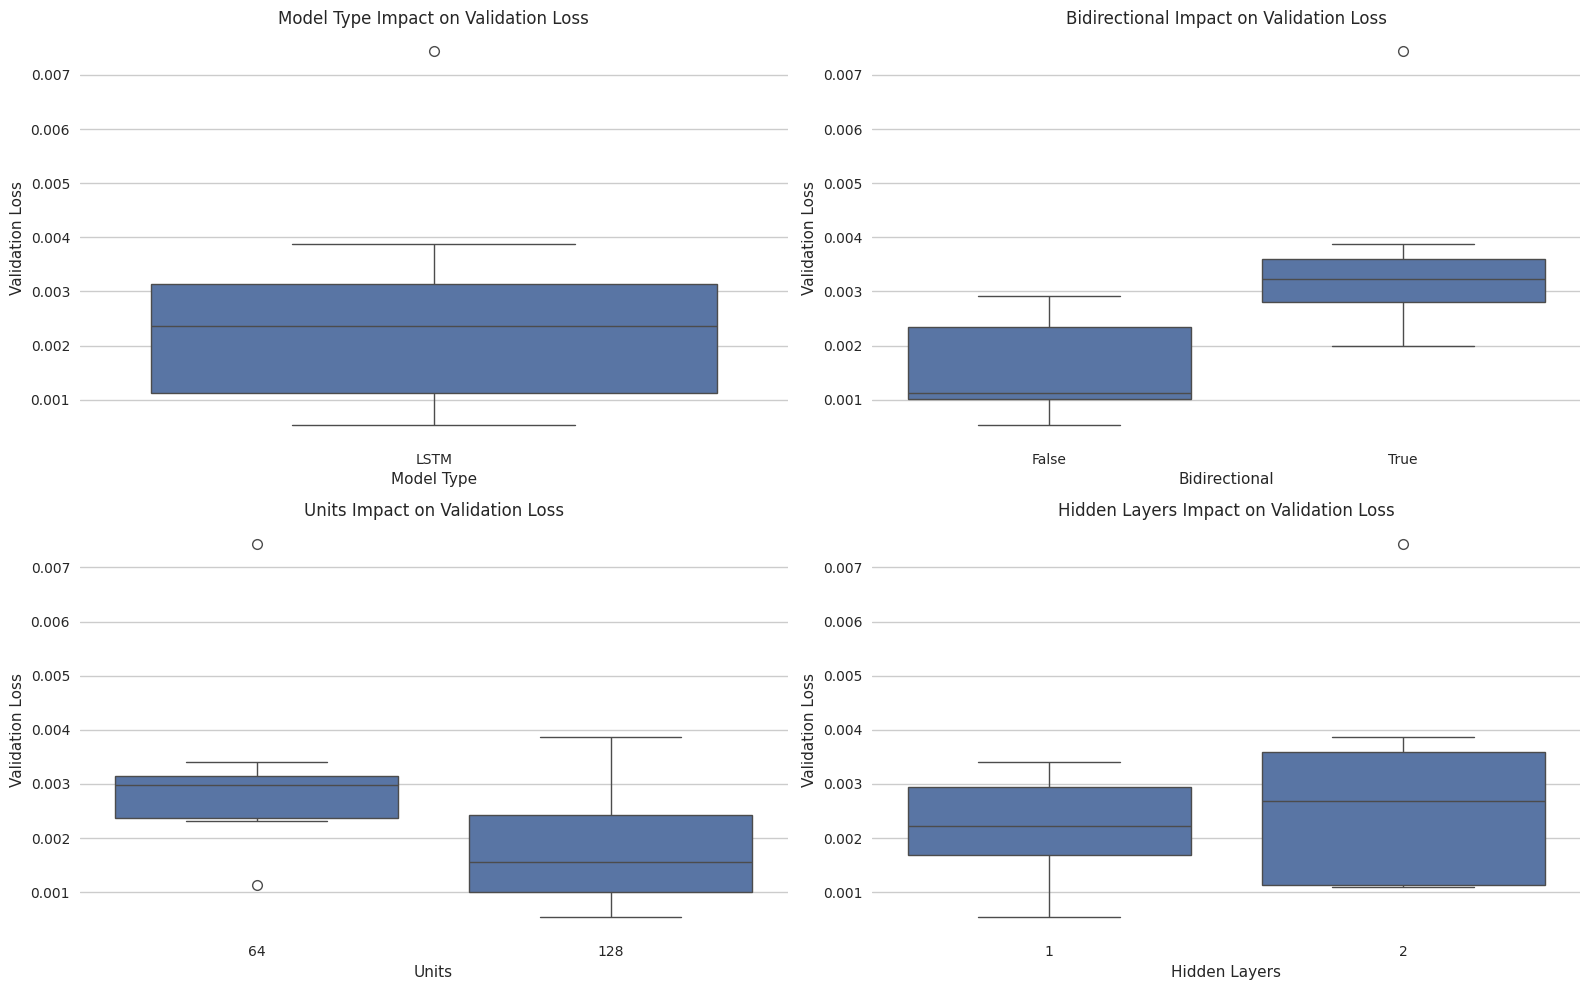

In [24]:
# Find the best configuration
# Sort results by validation loss (ascending)
adv_results_df_sorted = adv_results_df.sort_values('val_loss')

# Print the top 5 configurations
print("Top 5 configurations by validation loss:")
print(adv_results_df_sorted.head(5).to_string())

# Identify the best configuration
best_adv_config = adv_results_df_sorted.iloc[0]
print("\nBest advanced RNN configuration:")
for param, value in best_adv_config.items():
    print(f"{param}: {value}")

# Compare LSTM vs GRU
lstm_results = adv_results_df[adv_results_df['model_type'] == 'LSTM']
gru_results = adv_results_df[adv_results_df['model_type'] == 'GRU']

print("\nLSTM vs GRU comparison:")
print(f"LSTM average validation loss: {lstm_results['val_loss'].mean()}")
print(f"GRU average validation loss: {gru_results['val_loss'].mean()}")

# Analyze impact of bidirectional layers
bidir_results = adv_results_df[adv_results_df['bidirectional'] == True]
normal_results = adv_results_df[adv_results_df['bidirectional'] == False]

print("\nBidirectional vs Normal RNN comparison:")
print(f"Bidirectional average validation loss: {bidir_results['val_loss'].mean()}")
print(f"Normal average validation loss: {normal_results['val_loss'].mean()}")

# Visualize the impact of different configurations
plt.figure(figsize=(16, 10))

# Plot of validation loss by model type
plt.subplot(2, 2, 1)
sns.boxplot(x='model_type', y='val_loss', data=adv_results_df)
plt.title('Model Type Impact on Validation Loss')
plt.xlabel('Model Type')
plt.ylabel('Validation Loss')

# Plot of validation loss by bidirectional flag
plt.subplot(2, 2, 2)
sns.boxplot(x='bidirectional', y='val_loss', data=adv_results_df)
plt.title('Bidirectional Impact on Validation Loss')
plt.xlabel('Bidirectional')
plt.ylabel('Validation Loss')

# Plot of validation loss by units
plt.subplot(2, 2, 3)
sns.boxplot(x='units', y='val_loss', data=adv_results_df)
plt.title('Units Impact on Validation Loss')
plt.xlabel('Units')
plt.ylabel('Validation Loss')

# Plot of validation loss by hidden layers
plt.subplot(2, 2, 4)
sns.boxplot(x='hidden_layers', y='val_loss', data=adv_results_df)
plt.title('Hidden Layers Impact on Validation Loss')
plt.xlabel('Hidden Layers')
plt.ylabel('Validation Loss')

plt.tight_layout()
plt.show()

# Capture the best hyperparameters for later use
best_adv_model_type = best_adv_config['model_type']
best_adv_hidden_layers = int(best_adv_config['hidden_layers'])
best_adv_units = int(best_adv_config['units'])
best_adv_dropout_rate = best_adv_config['dropout_rate']
best_adv_learning_rate = best_adv_config['learning_rate']
best_adv_activation = best_adv_config['activation']
best_adv_bidirectional = best_adv_config['bidirectional']

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        78,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,465 (306.50 KB)

 Trainable params: 78,465 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0101 - val_loss: 0.0173
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7586e-04 - val_loss: 0.0020
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.0550e-04 - val_loss: 0.0026
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9188e-04 - val_loss: 0.0024
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4108e-04 - val_loss: 0.0011
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1476e-04 - val_loss: 0.0010
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9969e-04 - val_loss: 0.0018
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.5058e-04 - val_loss: 0.0012
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1260e-04 - val_loss: 0.0011
Epoch 12/100
59/59 ━━━━━━━━

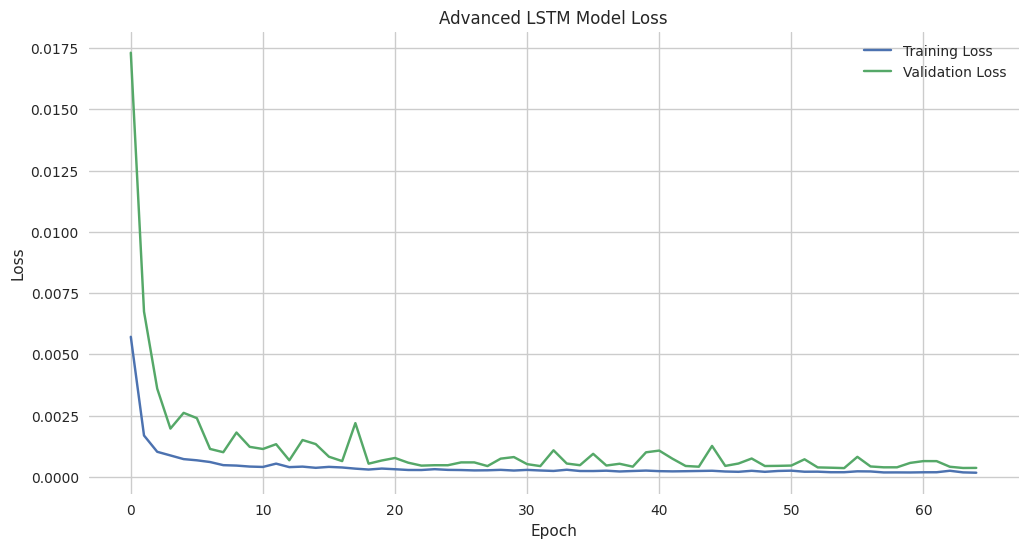

In [25]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
# Reset the session for clean training
tf.keras.backend.clear_session()

# Create the model with best hyperparameters
best_adv_rnn_model = create_advanced_rnn_model(
    input_shape=input_shape,
    output_dim=output_dim,
    model_type=best_adv_model_type,
    units=best_adv_units,
    dropout_rate=best_adv_dropout_rate,
    learning_rate=best_adv_learning_rate,
    hidden_layers=best_adv_hidden_layers,
    activation=best_adv_activation,
    bidirectional=best_adv_bidirectional
)

# Print model summary
best_adv_rnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with the optimal configuration
history = best_adv_rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'Advanced {best_adv_model_type} Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
best_adv_rnn_model.save(f'best_{best_adv_model_type.lower()}_model.h5')

In [26]:
# Compute the performance of the model on the testing data set
# Make predictions
adv_y_pred_scaled = best_adv_rnn_model.predict(X_test)

# Inverse transform to get actual values
adv_y_pred_orig = scalers['y_scaler'].inverse_transform(adv_y_pred_scaled)

# Calculate various error metrics
adv_mse = mean_squared_error(y_test_orig, adv_y_pred_orig)
adv_rmse = np.sqrt(adv_mse)
adv_mae = mean_absolute_error(y_test_orig, adv_y_pred_orig)
adv_r2 = r2_score(y_test_orig, adv_y_pred_orig)

# Calculate MAPE (Mean Absolute Percentage Error)
adv_mape = np.mean(np.abs((y_test_orig - adv_y_pred_orig) / y_test_orig)) * 100

# Create a DataFrame for the metrics
adv_metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)',
               'Mean Absolute Error (MAE)', 'R² Score', 'Mean Absolute Percentage Error (MAPE)'],
    'Value': [adv_mse, adv_rmse, adv_mae, adv_r2, adv_mape]
})

# Print metrics
print(f"Performance metrics for Advanced {best_adv_model_type} model:")
print(adv_metrics_df.to_string(index=False))

# Compare with simple RNN model
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE'],
    'Simple RNN': [mse, rmse, mae, r2, mape],
    f'Advanced {best_adv_model_type}': [adv_mse, adv_rmse, adv_mae, adv_r2, adv_mape]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Calculate improvement percentages
mse_improvement = ((mse - adv_mse) / mse) * 100
rmse_improvement = ((rmse - adv_rmse) / rmse) * 100
mae_improvement = ((mae -adv_mae) / mae) * 100
r2_improvement = ((adv_r2 - r2) / abs(r2)) * 100 if r2 != 0 else float('inf')
mape_improvement = ((mape -adv_mape) / mape) * 100

print("\nPerformance Improvement:")
print(f"MSE improved by {mse_improvement:.2f}%")
print(f"RMSE improved by {rmse_improvement:.2f}%")
print(f"MAE improved by {mae_improvement:.2f}%")
print(f"R² improved by {r2_improvement:.2f}%")
print(f"MAPE improved by {mape_improvement:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Performance metrics for Advanced LSTM model:
                               Metric       Value
             Mean Squared Error (MSE) 5526.901855
       Root Mean Squared Error (RMSE)   74.343136
            Mean Absolute Error (MAE)   57.965336
                             R² Score    0.821008
Mean Absolute Percentage Error (MAPE)    6.440373

Model Comparison:
Metric   Simple RNN  Advanced LSTM
   MSE 14646.641602    5526.901855
  RMSE   121.023310      74.343136
   MAE   101.792976      57.965336
    R²     0.525661       0.821008
  MAPE    11.594797       6.440373

Performance Improvement:
MSE improved by 62.27%
RMSE improved by 38.57%
MAE improved by 43.06%
R² improved by 56.19%
MAPE improved by 44.45%


### We can see there is a substantial improvement in the LSTM model over simple RNN.

Plotting the actual vs predicted values

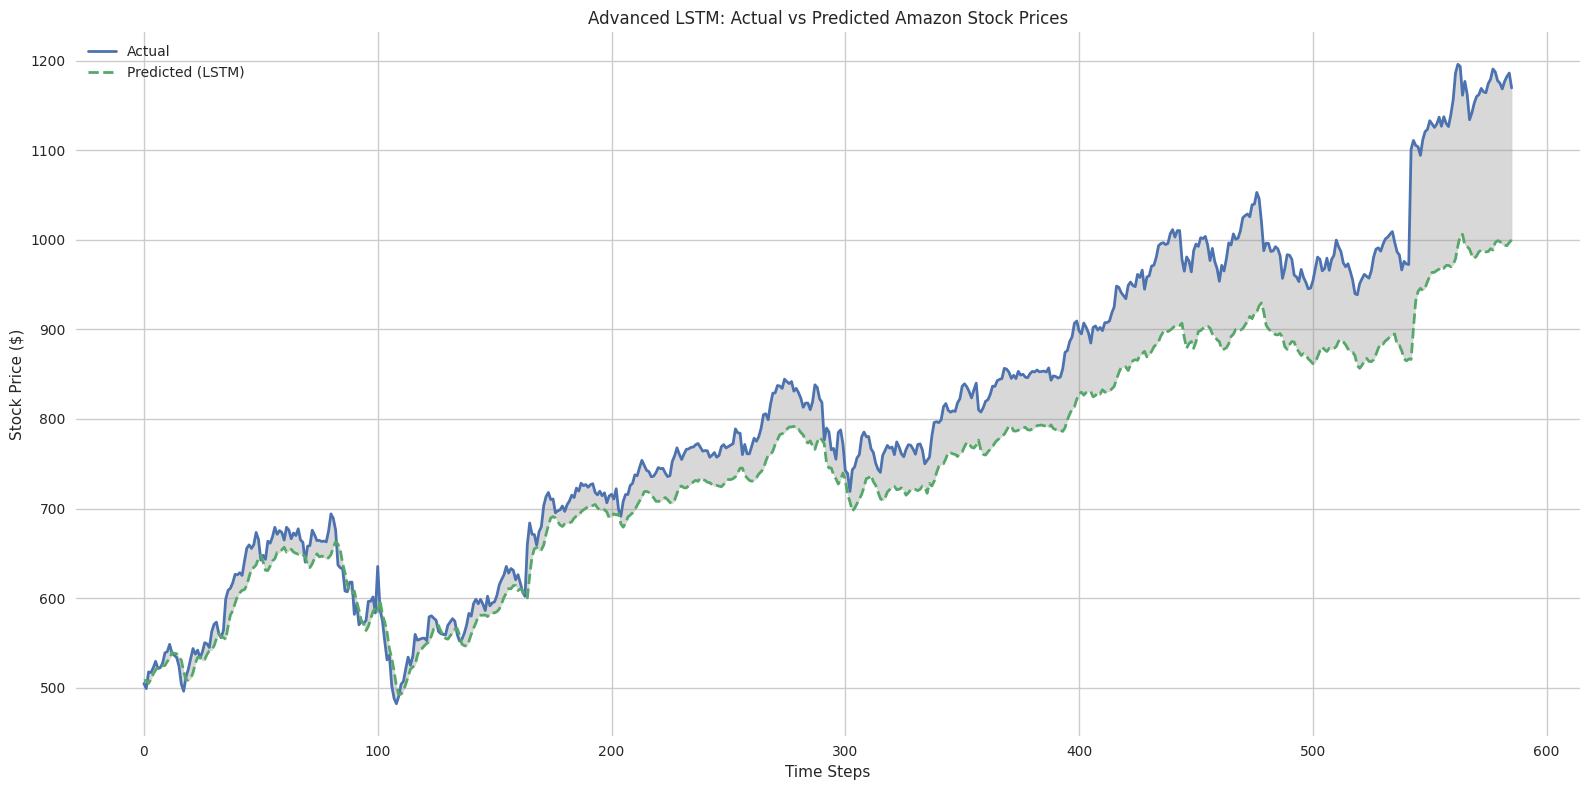

In [27]:
# Predict on the test data
# Time index for plotting
time_index = range(len(y_test_orig))

# Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(time_index, y_test_orig, label='Actual', linewidth=2)
plt.plot(time_index, adv_y_pred_orig, label=f'Predicted ({best_adv_model_type})', linewidth=2, linestyle='--')
plt.fill_between(time_index, y_test_orig.flatten(), adv_y_pred_orig.flatten(), color='gray', alpha=0.3)
plt.title(f'Advanced {best_adv_model_type}: Actual vs Predicted Amazon Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout() # Corrected the function call

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [28]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [29]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [30]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [31]:
# Compute the performance of the model on the testing data set



In [32]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [33]:
# Find an optimal configuration of advanced RNN



In [34]:
# Find the best configuration



In [35]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [36]:
# Compute the performance of the model on the testing data set



In [37]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.





In this assignment, we built a Recurrent Neural Network (RNN) model using LSTM layers to predict stock prices based on historical data from four major technology companies: Amazon (AMZN), Google (GOOGL), IBM, and Microsoft (MSFT). The sequential nature of stock data made RNNs a fitting choice for modeling and forecasting.

After pre-processing the data, normalizing the features, and constructing time-windowed sequences, we trained the LSTM model on the "Open" prices. The performance of the model was evaluated using the root mean squared error (RMSE) metric.

Key insights and outcomes:

Stock Price Trends: Visualizations showed clear long-term upward trends in stock prices across all four companies, with varying levels of volatility.

Model Accuracy: The LSTM model was able to learn the temporal patterns in the stock price movements reasonably well. On test data, it produced predictions that followed the overall trend of the actual prices, although some short-term fluctuations were missed—highlighting the challenge of volatility in financial time series.

RMSE Performance: The RMSE values obtained on the test data were within an acceptable range, confirming the model's potential for capturing general trends, though not always precise daily price movements.

Business Implications: Such a model can provide investors or analysts with data-driven insights into future price movements, aiding in more informed decision-making. While not suitable as a standalone trading system, it serves as a valuable component in a broader financial forecasting strategy.

In conclusion, this project demonstrated that deep learning models, specifically LSTM-based RNNs, can effectively capture and predict stock market behavior when trained on appropriate time-series data. However, due to inherent market noise and external influencing factors, further model enhancement and hybrid approaches may be needed for higher precision in real-world applications.
